#### Network analysis for error-related brain activity and anxiety dimensions

### Imports

In [1]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression


from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Load graphs

Define models for establishing network structire

In [14]:
dataset = 'train'
# dataset = 'test'
test = False

In [15]:
test_graphs = []
train_graphs = []

if test:
    print(f"Test dataset")
    
    ern_test_graph = nx.read_gml(f'../data/graphs/{dataset}/ern_graph.gml')
    ern_cov_test_graph = nx.read_gml(f'../data/graphs/{dataset}/ern_cov_graph.gml')
    crn_test_graph = nx.read_gml(f'../data/graphs/{dataset}/crn_graph.gml')
    ern_test_graph = nx.read_gml(f'../data/graphs/{dataset}/crn_cov_graph.gml')

    
    
else:
    print(f"Train dataset")
    
    ern_graph = nx.read_gml(f'../data/graphs/{dataset}/ern_graph.gml')
    ern_cov_graph = nx.read_gml(f'../data/graphs/{dataset}/ern_cov_graph.gml')
    crn_graph = nx.read_gml(f'../data/graphs/{dataset}/crn_graph.gml')
    crn_cov_graph = nx.read_gml(f'../data/graphs/{dataset}/crn_cov_graph.gml')
    
    train_graphs = [ern_graph, ern_cov_graph, crn_graph, crn_cov_graph]

Train dataset


In [16]:
train_graphs

---
## Degree Centrality measure

In [17]:
def calculate_degree_centrality(G):
    '''
    Returns pd DataFrame
    '''
    deg_centrality = nx.degree_centrality(G)
    deg_centrality = {k: v for k, v in sorted(deg_centrality.items(), key=lambda item: item[1], reverse=True)}
    deg_centrality = {k: [v] for k, v in deg_centrality.items()}
    deg_centrality_df = pd.DataFrame.from_dict(deg_centrality, orient='columns')
    
    return deg_centrality_df

Train

In [18]:
centralities = []

for this_graph in train_graphs:
    this_deg_centrality = calculate_degree_centrality(this_graph)
    centralities.append(this_deg_centrality)

In [19]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    for centrality in centralities:
        display(centrality)

BIS     BAS_D   INDEC_F        PS     IUS-P       ORD    HOARD  \
0  0.482759  0.448276  0.413793  0.413793  0.413793  0.413793  0.37931   

      G_SE      AMB  BAS_PRZY       REW    OBSESS        OT  DASS-21 Dep  \
0  0.37931  0.37931   0.37931  0.344828  0.344828  0.344828     0.344828   

        SES   OB_PERF      PRED      WBSI     STAND  DASS-21 Stress    STAI-T  \
0  0.344828  0.344828  0.344828  0.275862  0.275862        0.275862  0.275862   

   STAI-S Diff       PUN     T-CTR   BAS_NAG     e_ERN       RRQ     IUS-I  \
0     0.275862  0.275862  0.275862  0.275862  0.241379  0.241379  0.241379   

      CHECK      HARM  
0  0.206897  0.137931

BIS   INDEC_F        PS  BAS_PRZY    OBSESS        OT   BAS_NAG  \
0  0.484848  0.424242  0.424242  0.393939  0.363636  0.363636  0.333333   

   DASS-21 Dep       SES     IUS-P       ORD    HOARD      REW      AMB  \
0     0.333333  0.333333  0.333333  0.333333  0.30303  0.30303  0.30303   

     BAS_D     T-CTR      G_SE   OB_PERF  DASS-21 Stress     STAND      PRED  \
0  0.30303  0.272727  0.272727  0.272727        0.242424  0.242424  0.242424   

        RRQ      WBSI    STAI-T     IUS-I     CHECK  STAI-S Diff       PUN  \
0  0.212121  0.212121  0.212121  0.212121  0.212121     0.181818  0.181818   

      e_ERN       Age  Handness      HARM  performance    e_LT_F  
0  0.151515  0.121212  0.121212  0.121212     0.121212  0.090909

BIS     BAS_D     IUS-P        PS       SES       ORD  BAS_PRZY  \
0  0.517241  0.482759  0.482759  0.448276  0.448276  0.448276  0.413793   

     HOARD  INDEC_F      AMB     G_SE   OB_PERF    OBSESS        OT  \
0  0.37931  0.37931  0.37931  0.37931  0.344828  0.344828  0.344828   

   DASS-21 Dep       PUN      PRED   BAS_NAG  DASS-21 Stress    STAI-T  \
0     0.344828  0.344828  0.344828  0.310345        0.275862  0.275862   

   STAI-S Diff       REW     T-CTR      WBSI     STAND       RRQ     IUS-I  \
0     0.275862  0.275862  0.275862  0.241379  0.241379  0.206897  0.206897   

      CHECK     e_CRN      HARM  
0  0.206897  0.172414  0.137931

BIS     BAS_D  BAS_PRZY        PS   BAS_NAG    OBSESS   INDEC_F  \
0  0.454545  0.363636  0.363636  0.363636  0.363636  0.363636  0.363636   

         OT       ORD   OB_PERF       SES     IUS-P    HOARD  DASS-21 Dep  \
0  0.363636  0.363636  0.333333  0.333333  0.333333  0.30303      0.30303   

      PRED      G_SE  performance       REW       AMB  DASS-21 Stress  \
0  0.30303  0.272727     0.242424  0.242424  0.242424        0.242424   

      T-CTR     STAND     CHECK      WBSI    STAI-T  STAI-S Diff       PUN  \
0  0.242424  0.242424  0.212121  0.212121  0.212121     0.212121  0.212121   

      IUS-I     e_CRN  e_LT_F2_C       RRQ      HARM       Age  Handness  
0  0.212121  0.181818   0.181818  0.181818  0.151515  0.121212  0.121212

Test

In [20]:
centralities_test = []

if test:
    for this_graph in test_graphs:
        this_deg_centrality = calculate_degree_centrality(this_graph)
        centralities_test.append(this_deg_centrality)

In [21]:
centralities_test

[]

---

## Maximum Spanning Tree

In [22]:
def maximum_spanning_tree(G, edges_to_drop = None):
    G_ = G.copy()
    if edges_to_drop is not None:
        for k,v in edges_to_drop:
            if G_.has_edge(k, v):
                G_.remove_edge(k, v)
            else:
                print(f"The edge ({k}, {v}) does not exist in the graph.")
    # abs of weights
    for u, v, data in G_.edges(data=True):
        data['weight'] = abs(data['weight'])
    
    tree_ = nx.maximum_spanning_tree(G_, 'prim')
    
    return (G_, tree_)  

In [23]:
G_ = train_graphs[1]
G_, T_ = maximum_spanning_tree(G_, [('e_ERN', 'HOARD')])

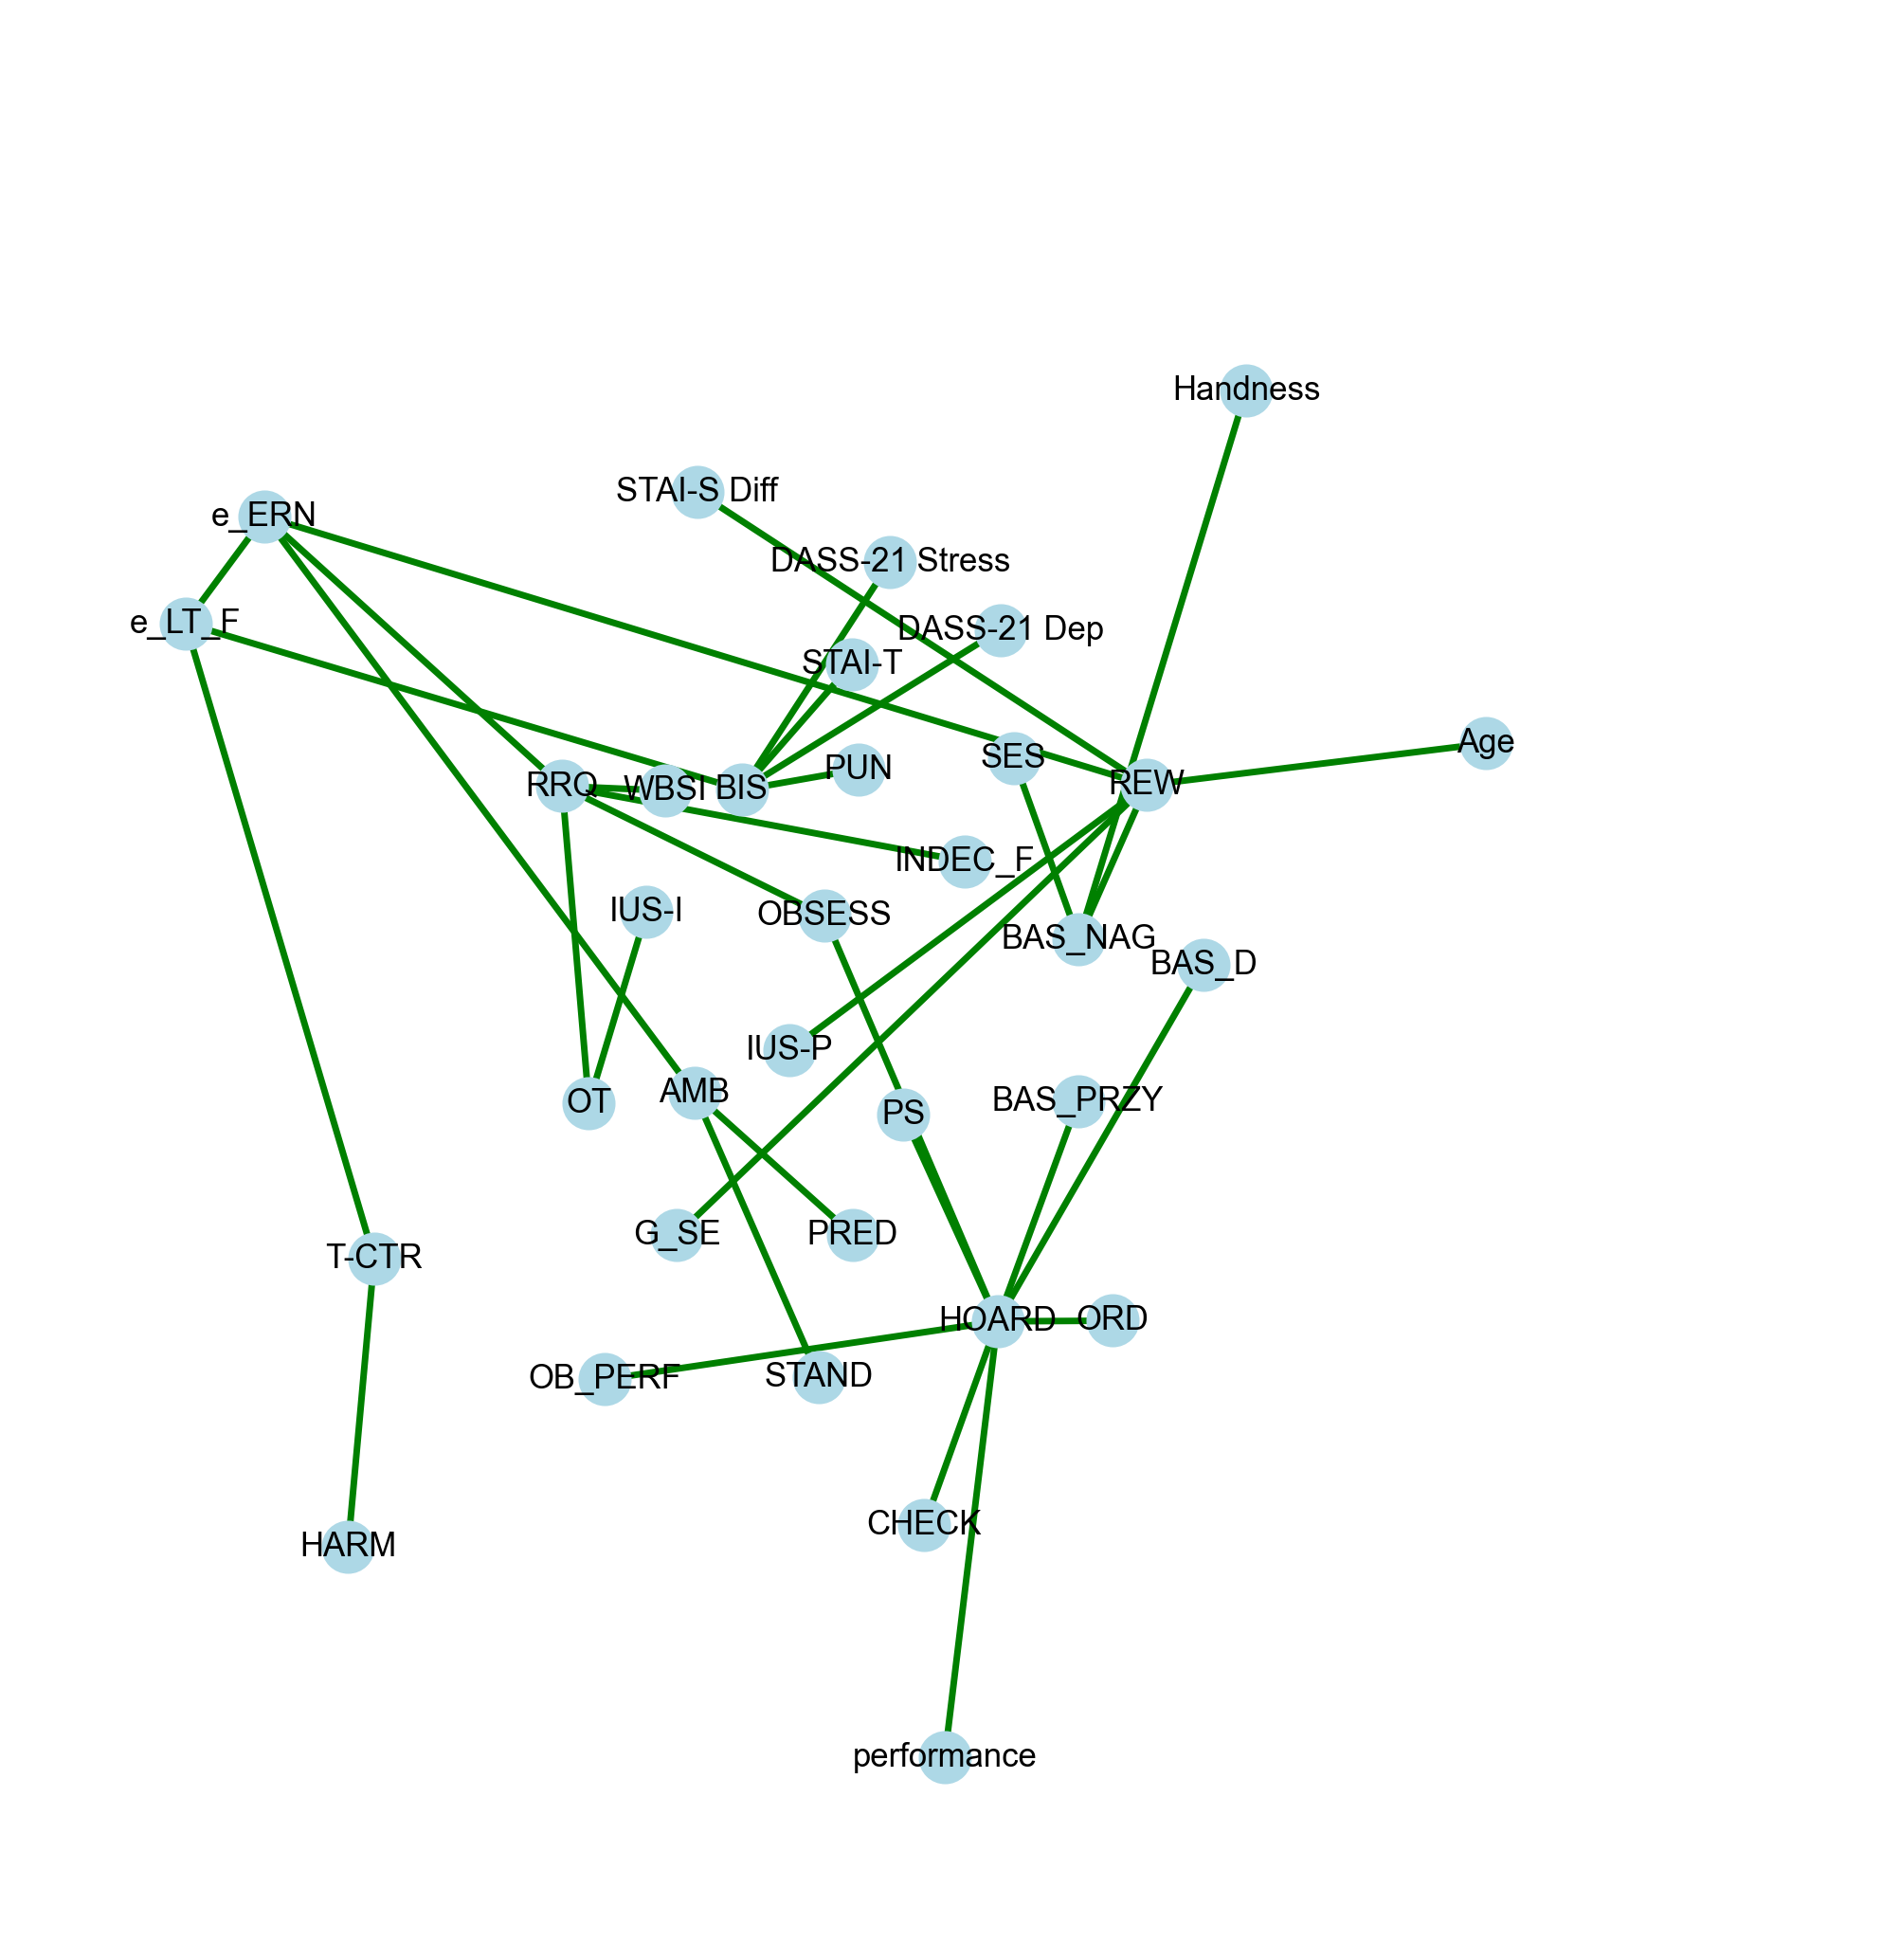

In [24]:
cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 9
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
sns.set_style("white")
palette = sns.color_palette("colorblind")

fig = plt.figure(3, figsize=(10*cm, 10*cm))
axes = fig.add_axes([0,0,1,1], aspect=1)
axes.set_xlim([-1,1.3])
axes.set_ylim([-1.2,1.2])

    

# Find the maximum spanning tree
# T = nx.maximum_spanning_tree(G_)

# Visualize the graph and the minimum spanning tree
pos = nx.spring_layout(G_, scale=1, seed=1)
nx.draw_networkx_nodes(G_, pos, node_color="lightblue", node_size=50)
# nx.draw_networkx_edges(G_, pos, edge_color="grey")
nx.draw_networkx_labels(G_, pos, font_size=5, font_family="sans-serif")
# nx.draw_networkx_edge_labels(
#     G_, pos, edge_labels={(u, v): d["weight"] for u, v, d in G_.edges(data=True)}
# )
nx.draw_networkx_edges(T_, pos, edge_color="green", width=1)
plt.axis("off")
plt.show()

In [25]:
deg_centrality_tree = calculate_degree_centrality(T_)
deg_centrality_tree

HOARD       REW       RRQ       BIS     e_ERN    e_LT_F       AMB  \
0  0.242424  0.181818  0.151515  0.151515  0.121212  0.090909  0.090909   

    BAS_NAG     T-CTR    OBSESS  ...       PUN     IUS-I     CHECK      G_SE  \
0  0.090909  0.060606  0.060606  ...  0.030303  0.030303  0.030303  0.030303   

      STAND       ORD   OB_PERF      PRED      HARM  performance  
0  0.030303  0.030303  0.030303  0.030303  0.030303     0.030303  

[1 rows x 34 columns]

---

## Shortest paths from ERN

In [26]:
def dijkstra_shortest_path(G, source, edges_to_drop = None):
    G_ = G.copy()
    if edges_to_drop is not None:
        for k,v in edges_to_drop:
            if G_.has_edge(k, v):
                G_.remove_edge(k, v)
            else:
                print(f"The edge ({k}, {v}) does not exist in the graph.")
    # abs of weights
    for u, v, data in G_.edges(data=True):
        data['weight'] = abs(data['weight'])
    
    # reverse of weights to make the highest weight the best
    for u, v, data in G_.edges(data=True):
        data['weight'] = 1/data['weight']
    
    path_ = nx.single_source_dijkstra_path(G_, source)
    
    return path_  

In [27]:
def simple_shortest_path(G, source, edges_to_drop = None):
    G_ = G.copy()
    if edges_to_drop is not None:
        for k,v in edges_to_drop:
            if G_.has_edge(k, v):
                G_.remove_edge(k, v)
            else:
                print(f"The edge ({k}, {v}) does not exist in the graph.")
    
    path_ = nx.single_source_shortest_path(G_, source)
    
    return path_  

**ERN**

- weighed

In [28]:
G_ = train_graphs[0]
path = dijkstra_shortest_path(G_, 'e_ERN', [('e_ERN', 'HOARD')])
path

{'e_ERN': ['e_ERN'],
 'RRQ': ['e_ERN', 'RRQ'],
 'WBSI': ['e_ERN', 'RRQ', 'WBSI'],
 'REW': ['e_ERN', 'RRQ', 'BIS', 'BAS_NAG', 'REW'],
 'G_SE': ['e_ERN', 'RRQ', 'BIS', 'G_SE'],
 'AMB': ['e_ERN', 'RRQ', 'BIS', 'AMB'],
 'STAND': ['e_ERN', 'RRQ', 'OT', 'OB_PERF', 'STAND'],
 'BIS': ['e_ERN', 'RRQ', 'BIS'],
 'OBSESS': ['e_ERN', 'RRQ', 'OBSESS'],
 'OT': ['e_ERN', 'RRQ', 'OT'],
 'INDEC_F': ['e_ERN', 'RRQ', 'INDEC_F'],
 'HOARD': ['e_ERN', 'RRQ', 'INDEC_F', 'HOARD'],
 'DASS-21 Dep': ['e_ERN', 'RRQ', 'OBSESS', 'DASS-21 Dep'],
 'STAI-S Diff': ['e_ERN', 'RRQ', 'BIS', 'STAI-S Diff'],
 'BAS_PRZY': ['e_ERN', 'RRQ', 'OBSESS', 'BAS_PRZY'],
 'ORD': ['e_ERN', 'RRQ', 'OBSESS', 'ORD'],
 'PRED': ['e_ERN', 'RRQ', 'OBSESS', 'PRED'],
 'DASS-21 Stress': ['e_ERN', 'RRQ', 'OBSESS', 'DASS-21 Dep', 'DASS-21 Stress'],
 'BAS_D': ['e_ERN', 'RRQ', 'BIS', 'BAS_D'],
 'PUN': ['e_ERN', 'RRQ', 'INDEC_F', 'PUN'],
 'OB_PERF': ['e_ERN', 'RRQ', 'OT', 'OB_PERF'],
 'PS': ['e_ERN', 'RRQ', 'INDEC_F', 'PS'],
 'SES': ['e_ERN', 'RRQ', '

- non weighed

In [29]:
G_ = train_graphs[0]
path = simple_shortest_path(G_, 'e_ERN', [('e_ERN', 'HOARD')])
path

{'e_ERN': ['e_ERN'],
 'RRQ': ['e_ERN', 'RRQ'],
 'WBSI': ['e_ERN', 'WBSI'],
 'REW': ['e_ERN', 'REW'],
 'G_SE': ['e_ERN', 'G_SE'],
 'AMB': ['e_ERN', 'AMB'],
 'STAND': ['e_ERN', 'STAND'],
 'BIS': ['e_ERN', 'RRQ', 'BIS'],
 'OBSESS': ['e_ERN', 'RRQ', 'OBSESS'],
 'OT': ['e_ERN', 'RRQ', 'OT'],
 'INDEC_F': ['e_ERN', 'RRQ', 'INDEC_F'],
 'DASS-21 Stress': ['e_ERN', 'WBSI', 'DASS-21 Stress'],
 'STAI-T': ['e_ERN', 'WBSI', 'STAI-T'],
 'STAI-S Diff': ['e_ERN', 'WBSI', 'STAI-S Diff'],
 'PS': ['e_ERN', 'WBSI', 'PS'],
 'IUS-P': ['e_ERN', 'WBSI', 'IUS-P'],
 'BAS_D': ['e_ERN', 'REW', 'BAS_D'],
 'BAS_PRZY': ['e_ERN', 'REW', 'BAS_PRZY'],
 'BAS_NAG': ['e_ERN', 'REW', 'BAS_NAG'],
 'HARM': ['e_ERN', 'REW', 'HARM'],
 'CHECK': ['e_ERN', 'G_SE', 'CHECK'],
 'PUN': ['e_ERN', 'G_SE', 'PUN'],
 'T-CTR': ['e_ERN', 'G_SE', 'T-CTR'],
 'PRED': ['e_ERN', 'G_SE', 'PRED'],
 'IUS-I': ['e_ERN', 'G_SE', 'IUS-I'],
 'HOARD': ['e_ERN', 'AMB', 'HOARD'],
 'ORD': ['e_ERN', 'STAND', 'ORD'],
 'OB_PERF': ['e_ERN', 'STAND', 'OB_PERF'],


**ERN + cov**

- weighed

In [34]:
G_ = train_graphs[1]
path = dijkstra_shortest_path(G_, 'e_ERN', [('e_ERN', 'HOARD')])
path

{'e_ERN': ['e_ERN'],
 'e_LT_F': ['e_ERN', 'e_LT_F'],
 'RRQ': ['e_ERN', 'RRQ'],
 'REW': ['e_ERN', 'e_LT_F', 'BIS', 'BAS_NAG', 'REW'],
 'AMB': ['e_ERN', 'e_LT_F', 'BIS', 'AMB'],
 'BIS': ['e_ERN', 'e_LT_F', 'BIS'],
 'T-CTR': ['e_ERN', 'RRQ', 'OT', 'T-CTR'],
 'OBSESS': ['e_ERN', 'RRQ', 'OBSESS'],
 'OT': ['e_ERN', 'RRQ', 'OT'],
 'WBSI': ['e_ERN', 'RRQ', 'WBSI'],
 'INDEC_F': ['e_ERN', 'RRQ', 'INDEC_F'],
 'DASS-21 Stress': ['e_ERN', 'e_LT_F', 'BIS', 'DASS-21 Stress'],
 'DASS-21 Dep': ['e_ERN', 'RRQ', 'OBSESS', 'DASS-21 Dep'],
 'STAI-T': ['e_ERN', 'e_LT_F', 'BIS', 'STAI-T'],
 'STAI-S Diff': ['e_ERN', 'e_LT_F', 'BIS', 'STAI-S Diff'],
 'BAS_D': ['e_ERN', 'e_LT_F', 'BIS', 'BAS_NAG', 'BAS_D'],
 'BAS_NAG': ['e_ERN', 'e_LT_F', 'BIS', 'BAS_NAG'],
 'PUN': ['e_ERN', 'e_LT_F', 'BIS', 'PUN'],
 'G_SE': ['e_ERN', 'e_LT_F', 'BIS', 'G_SE'],
 'PS': ['e_ERN', 'RRQ', 'OT', 'OB_PERF', 'PS'],
 'STAND': ['e_ERN', 'e_LT_F', 'BIS', 'AMB', 'STAND'],
 'HOARD': ['e_ERN', 'RRQ', 'OBSESS', 'HOARD'],
 'Age': ['e_ERN', 'e_

- non weighed

In [31]:
G_ = train_graphs[1]
path = simple_shortest_path(G_, 'e_ERN', [('e_ERN', 'HOARD')])
path

{'e_ERN': ['e_ERN'],
 'e_LT_F': ['e_ERN', 'e_LT_F'],
 'RRQ': ['e_ERN', 'RRQ'],
 'REW': ['e_ERN', 'REW'],
 'AMB': ['e_ERN', 'AMB'],
 'BIS': ['e_ERN', 'e_LT_F', 'BIS'],
 'T-CTR': ['e_ERN', 'e_LT_F', 'T-CTR'],
 'OBSESS': ['e_ERN', 'RRQ', 'OBSESS'],
 'OT': ['e_ERN', 'RRQ', 'OT'],
 'WBSI': ['e_ERN', 'RRQ', 'WBSI'],
 'INDEC_F': ['e_ERN', 'RRQ', 'INDEC_F'],
 'Age': ['e_ERN', 'REW', 'Age'],
 'STAI-S Diff': ['e_ERN', 'REW', 'STAI-S Diff'],
 'BAS_D': ['e_ERN', 'REW', 'BAS_D'],
 'BAS_PRZY': ['e_ERN', 'REW', 'BAS_PRZY'],
 'BAS_NAG': ['e_ERN', 'REW', 'BAS_NAG'],
 'G_SE': ['e_ERN', 'REW', 'G_SE'],
 'IUS-P': ['e_ERN', 'REW', 'IUS-P'],
 'PRED': ['e_ERN', 'AMB', 'PRED'],
 'STAND': ['e_ERN', 'AMB', 'STAND'],
 'DASS-21 Stress': ['e_ERN', 'e_LT_F', 'BIS', 'DASS-21 Stress'],
 'DASS-21 Dep': ['e_ERN', 'e_LT_F', 'BIS', 'DASS-21 Dep'],
 'STAI-T': ['e_ERN', 'e_LT_F', 'BIS', 'STAI-T'],
 'PUN': ['e_ERN', 'e_LT_F', 'BIS', 'PUN'],
 'PS': ['e_ERN', 'e_LT_F', 'BIS', 'PS'],
 'HARM': ['e_ERN', 'e_LT_F', 'T-CTR', 'HARM

**CRN**

- weighed

In [33]:
G_ = train_graphs[2]
path = dijkstra_shortest_path(G_, 'e_CRN')
path

{'e_CRN': ['e_CRN'],
 'BAS_D': ['e_CRN', 'BAS_D'],
 'BAS_PRZY': ['e_CRN', 'BAS_PRZY'],
 'HOARD': ['e_CRN', 'OB_PERF', 'HOARD'],
 'OB_PERF': ['e_CRN', 'OB_PERF'],
 'IUS-P': ['e_CRN', 'BAS_PRZY', 'PRED', 'IUS-P'],
 'CHECK': ['e_CRN', 'OB_PERF', 'CHECK'],
 'OT': ['e_CRN', 'OB_PERF', 'OT'],
 'HARM': ['e_CRN', 'OB_PERF', 'HARM'],
 'T-CTR': ['e_CRN', 'OB_PERF', 'T-CTR'],
 'PS': ['e_CRN', 'BAS_D', 'PS'],
 'PRED': ['e_CRN', 'BAS_PRZY', 'PRED'],
 'STAND': ['e_CRN', 'OB_PERF', 'STAND'],
 'DASS-21 Stress': ['e_CRN', 'BAS_D', 'BIS', 'DASS-21 Stress'],
 'DASS-21 Dep': ['e_CRN', 'OB_PERF', 'OT', 'OBSESS', 'DASS-21 Dep'],
 'STAI-T': ['e_CRN', 'BAS_D', 'BAS_NAG', 'SES', 'STAI-T'],
 'BIS': ['e_CRN', 'BAS_D', 'BIS'],
 'BAS_NAG': ['e_CRN', 'BAS_D', 'BAS_NAG'],
 'ORD': ['e_CRN', 'BAS_PRZY', 'ORD'],
 'INDEC_F': ['e_CRN', 'BAS_D', 'BAS_NAG', 'SES', 'INDEC_F'],
 'REW': ['e_CRN', 'BAS_PRZY', 'REW'],
 'SES': ['e_CRN', 'BAS_D', 'BAS_NAG', 'SES'],
 'STAI-S Diff': ['e_CRN', 'BAS_D', 'BIS', 'STAI-S Diff'],
 'OBSES

- non weighed

In [165]:
G_ = train_graphs[2]
path = simple_shortest_path(G_, 'e_CRN')
path

{'e_CRN': ['e_CRN'],
 'BAS_D': ['e_CRN', 'BAS_D'],
 'BAS_PRZY': ['e_CRN', 'BAS_PRZY'],
 'HOARD': ['e_CRN', 'HOARD'],
 'OB_PERF': ['e_CRN', 'OB_PERF'],
 'IUS-P': ['e_CRN', 'IUS-P'],
 'DASS-21 Stress': ['e_CRN', 'BAS_D', 'DASS-21 Stress'],
 'DASS-21 Dep': ['e_CRN', 'BAS_D', 'DASS-21 Dep'],
 'STAI-T': ['e_CRN', 'BAS_D', 'STAI-T'],
 'BIS': ['e_CRN', 'BAS_D', 'BIS'],
 'BAS_NAG': ['e_CRN', 'BAS_D', 'BAS_NAG'],
 'ORD': ['e_CRN', 'BAS_D', 'ORD'],
 'INDEC_F': ['e_CRN', 'BAS_D', 'INDEC_F'],
 'REW': ['e_CRN', 'BAS_D', 'REW'],
 'PS': ['e_CRN', 'BAS_D', 'PS'],
 'SES': ['e_CRN', 'BAS_D', 'SES'],
 'STAI-S Diff': ['e_CRN', 'BAS_PRZY', 'STAI-S Diff'],
 'OBSESS': ['e_CRN', 'BAS_PRZY', 'OBSESS'],
 'PUN': ['e_CRN', 'BAS_PRZY', 'PUN'],
 'PRED': ['e_CRN', 'BAS_PRZY', 'PRED'],
 'CHECK': ['e_CRN', 'HOARD', 'CHECK'],
 'AMB': ['e_CRN', 'HOARD', 'AMB'],
 'OT': ['e_CRN', 'OB_PERF', 'OT'],
 'HARM': ['e_CRN', 'OB_PERF', 'HARM'],
 'T-CTR': ['e_CRN', 'OB_PERF', 'T-CTR'],
 'STAND': ['e_CRN', 'OB_PERF', 'STAND'],
 'WBS

**CRN + cov**

- weighed

In [166]:
G_ = train_graphs[3]
path = dijkstra_shortest_path(G_, 'e_CRN')
path

{'e_CRN': ['e_CRN'],
 'e_LT_F2_C': ['e_CRN', 'e_LT_F2_C'],
 'BAS_D': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'BAS_D'],
 'BAS_PRZY': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'BAS_PRZY'],
 'HOARD': ['e_CRN', 'e_LT_F2_C', 'CHECK', 'HOARD'],
 'OB_PERF': ['e_CRN', 'e_LT_F2_C', 'CHECK', 'OB_PERF'],
 'BAS_NAG': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG'],
 'CHECK': ['e_CRN', 'e_LT_F2_C', 'CHECK'],
 'REW': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'REW'],
 'performance': ['e_CRN', 'e_LT_F2_C', 'performance'],
 'Age': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'REW', 'Age'],
 'Sex': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'Sex'],
 'Handness': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'SES', 'INDEC_F', 'Handness'],
 'BIS': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'BIS'],
 'ORD': ['e_CRN', 'e_LT_F2_C', 'CHECK', 'ORD'],
 'AMB': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'AMB'],
 'IUS-P': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'SES', 'STAI-T', 'IUS-I', 'IUS-P'],
 'SES': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'SES'],
 'STAI-S Diff': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG', 'BIS', 'STA

- non weighed

In [167]:
G_ = train_graphs[3]
path = simple_shortest_path(G_, 'e_CRN')
path

{'e_CRN': ['e_CRN'],
 'e_LT_F2_C': ['e_CRN', 'e_LT_F2_C'],
 'BAS_D': ['e_CRN', 'BAS_D'],
 'BAS_PRZY': ['e_CRN', 'BAS_PRZY'],
 'HOARD': ['e_CRN', 'HOARD'],
 'OB_PERF': ['e_CRN', 'OB_PERF'],
 'BAS_NAG': ['e_CRN', 'e_LT_F2_C', 'BAS_NAG'],
 'CHECK': ['e_CRN', 'e_LT_F2_C', 'CHECK'],
 'REW': ['e_CRN', 'e_LT_F2_C', 'REW'],
 'performance': ['e_CRN', 'e_LT_F2_C', 'performance'],
 'Sex': ['e_CRN', 'BAS_D', 'Sex'],
 'DASS-21 Stress': ['e_CRN', 'BAS_D', 'DASS-21 Stress'],
 'DASS-21 Dep': ['e_CRN', 'BAS_D', 'DASS-21 Dep'],
 'STAI-T': ['e_CRN', 'BAS_D', 'STAI-T'],
 'BIS': ['e_CRN', 'BAS_D', 'BIS'],
 'OBSESS': ['e_CRN', 'BAS_D', 'OBSESS'],
 'ORD': ['e_CRN', 'BAS_D', 'ORD'],
 'INDEC_F': ['e_CRN', 'BAS_D', 'INDEC_F'],
 'PS': ['e_CRN', 'BAS_D', 'PS'],
 'IUS-P': ['e_CRN', 'BAS_D', 'IUS-P'],
 'SES': ['e_CRN', 'BAS_D', 'SES'],
 'Age': ['e_CRN', 'BAS_PRZY', 'Age'],
 'STAI-S Diff': ['e_CRN', 'BAS_PRZY', 'STAI-S Diff'],
 'PUN': ['e_CRN', 'BAS_PRZY', 'PUN'],
 'PRED': ['e_CRN', 'BAS_PRZY', 'PRED'],
 'AMB': ['e_

---

## Neighbours of STAI-T

In [170]:
G = train_graphs[1].copy()
node = 'STAI-T'
neighbors = list(G.neighbors(node))
neighbors

['BIS', 'WBSI', 'DASS-21 Stress', 'DASS-21 Dep', 'PUN', 'IUS-I', 'SES']

In [171]:
G = train_graphs[1].copy()
node = 'DASS-21 Dep'
neighbors = list(G.neighbors(node))
neighbors

['BIS',
 'OBSESS',
 'INDEC_F',
 'PS',
 'BAS_D',
 'DASS-21 Stress',
 'STAI-T',
 'STAI-S Diff',
 'BAS_PRZY',
 'SES',
 'performance']

In [182]:
G = train_graphs[1].copy()
node = 'STAND'
neighbors = list(G.neighbors(node))
neighbors

['AMB', 'BIS', 'PS', 'OT', 'OB_PERF', 'SES', 'performance', 'ORD']

---

## Stability measures

### Bootstraping of network

In [18]:
def boostrap_network(X, model, nodes_list, N=10):
    
    # Create an empty list to store the bootstrapped precision matrices
    bootstrapped_precisions_df = []
    
    # Create an empty list to store the linkages between features
    bootstrapped_links = []
    
    bootstraped_links_concatenated_df = pd.DataFrame({})
    
    for i in range(N):
        # Generate a bootstrap sample
        bootstrap_X = resample(X, replace=True)
        bootstrap_X /= bootstrap_X.std(axis=0)

        # Fit the edge model to the bootstrap sample
        bootstrapped_model = model.fit(bootstrap_X)

        # Extract the precision matrix from the model
        bootstrapped_precision_df = pd.DataFrame(model.precision_, columns = nodes_list, index = nodes_list)
        bootstrapped_precision_df = bootstrapped_precision_df.where(np.triu(np.ones(bootstrapped_precision_df.shape)).astype(np.bool))

        # Append the matrix to the list
        bootstrapped_precisions_df.append(bootstrapped_precision_df)

        # Extract the list of linkages between nodes
        links = bootstrapped_precision_df.stack().reset_index()
        links.columns = ['var1', 'var2','weight']
        
        # Remove self-links
        links=links.loc[(links['var1'] != links['var2'])]
        
        # Remove links between EEG features
        links = links[~((links['var1'].str.contains("e_")) & (links['var2'].str.contains("e_")))]
        
        # # Zero links with low power
        # links = links.loc[abs(links['weight']) > 0.05]
        
        # Create column that store edges
        links['edge'] = links['var1'] + '_' + links['var2']
        
        # Annotate non-zero links
        links['non_zero'] = links['weight'].apply(lambda x:1 if x != 0 else 0)
        

        # Append the list of linkages to the list of bootstrapped links
        bootstrapped_links.append(links)
    
    # Concatenate all of the bootstrapped linkages into one dataframe
    bootstrapped_links_df = pd.concat(bootstrapped_links, axis=0, ignore_index=True)
    
    # Add summary of means and 95% CI of edges weights
    bootstrapped_links_df['mean'] = bootstrapped_links_df.groupby(['var1', 'var2'])['weight'].transform(np.mean)
    bootstrapped_links_df['ci_lower'] = bootstrapped_links_df.groupby(['var1', 'var2'])['weight'].transform(np.percentile, q=2.5)
    bootstrapped_links_df['ci_upper'] = bootstrapped_links_df.groupby(['var1', 'var2'])['weight'].transform(np.percentile, q=97.5)
    
    # Sort edges by weights' means
    bootstrapped_links_df.sort_values(by="mean", ascending=False, inplace=True)
    
    return bootstrapped_links_df

In [19]:
def bootstrap_model(model):
    '''
    Params:
        model: df of shape (features x samples)
        
    Returns:
        bootstraped_links_concatenated_df: df with boostraped samples 
    '''
    X = model.to_numpy()

    edge_model = GraphicalLassoCV(
        alphas=np.logspace(-5, 1, num=20),
        cv=10,
    )
    
    bootstraped_links_concatenated_df = boostrap_network(X, edge_model, nodes_list=model.columns, N=100)
    
    return bootstraped_links_concatenated_df
  

In [ ]:
def plot_bootstraping_results(bootstraped_links_concatenated_df):
    sns.set(rc={'figure.figsize':(20 , 120)})

    ax = sns.pointplot(
        x="weight", 
        y="edge", 
        data=bootstraped_links_concatenated_df, 
        orient= 'h',
        join=False,
    )

    ax.axvline(x=0, color='violet')

    mean_df = bootstraped_links_concatenated_df.groupby(['edge'])[['weight', 'non_zero']].mean()
    mean_df = mean_df.sort_values(by='weight', ascending=False)

    for i, row in enumerate(mean_df.itertuples()):

        x_value, mean, non_zero_mean = row

        plt.annotate(
            round(non_zero_mean, 2),               # label text
            (mean, i),                    # (x, y)
            textcoords="offset points",   
            xytext=(5, 0),               # (x, y) offset amount
            ha='left'
        )
        
    plt.show()

In [48]:
def plot_eeg_links_bootstrapping_results(bootstraped_links_concatenated_df):
    sns.set(rc={'figure.figsize':(10 , 20)})
    
    eeg_bootstraped_links_concatenated_df = bootstraped_links_concatenated_df[(bootstraped_links_concatenated_df['var1'].str.contains('e_ERN')) | (bootstraped_links_concatenated_df['var1'].str.contains('e_PCA'))]

    ax = sns.pointplot(
        x="weight", 
        y="edge", 
        data=eeg_bootstraped_links_concatenated_df, 
        orient= 'h',
        join=False,
    )

    ax.axvline(x=0, color='violet')

    mean_df = eeg_bootstraped_links_concatenated_df.groupby(['edge'])[['weight', 'non_zero']].mean()
    mean_df = mean_df.sort_values(by='weight', ascending=False)

    for i, row in enumerate(mean_df.itertuples()):

        x_value, mean, non_zero_mean = row

        plt.annotate(
            round(non_zero_mean, 2),               # label text
            (mean, i),                    # (x, y)
            textcoords="offset points",   
            xytext=(5, 0),               # (x, y) offset amount
            ha='left'
        )

    plt.show()
    
    


Bootstrap created models

In [20]:
if test:
    print(f"Test set")
    bootstrap_samples_models_test = []

    for model in models:
        this_bootstrap_samples = bootstrap_model(model)
        bootstrap_samples_models_test.append(this_bootstrap_samples)
        
else:
    print(f"Train set")
    
    bootstrap_samples_models = []

    for model in models:
        this_bootstrap_samples = bootstrap_model(model)
        bootstrap_samples_models.append(this_bootstrap_samples)

Train set


Plot 95% CI of precision weights toghether with number how often an edge was estimated non-zero

In [ ]:
if test:
    print(f"Test set")

    for i,model in enumerate(bootstrap_samples_models_test):
        plt.figure(i)
        plot_bootstraping_results(model)
        
        
else:
    print(f"Train set")
    
    for i,model in enumerate(bootstrap_samples_models):
        plt.figure(i)
        plot_bootstraping_results(model)

Only EEG links

Train set


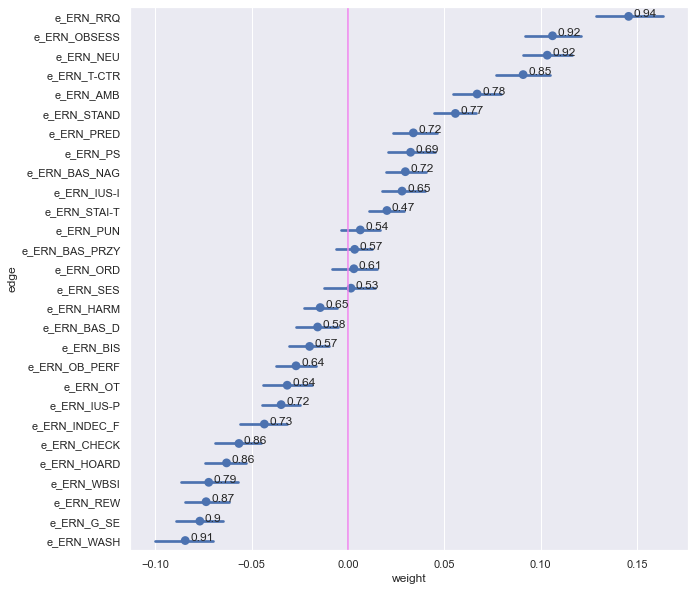

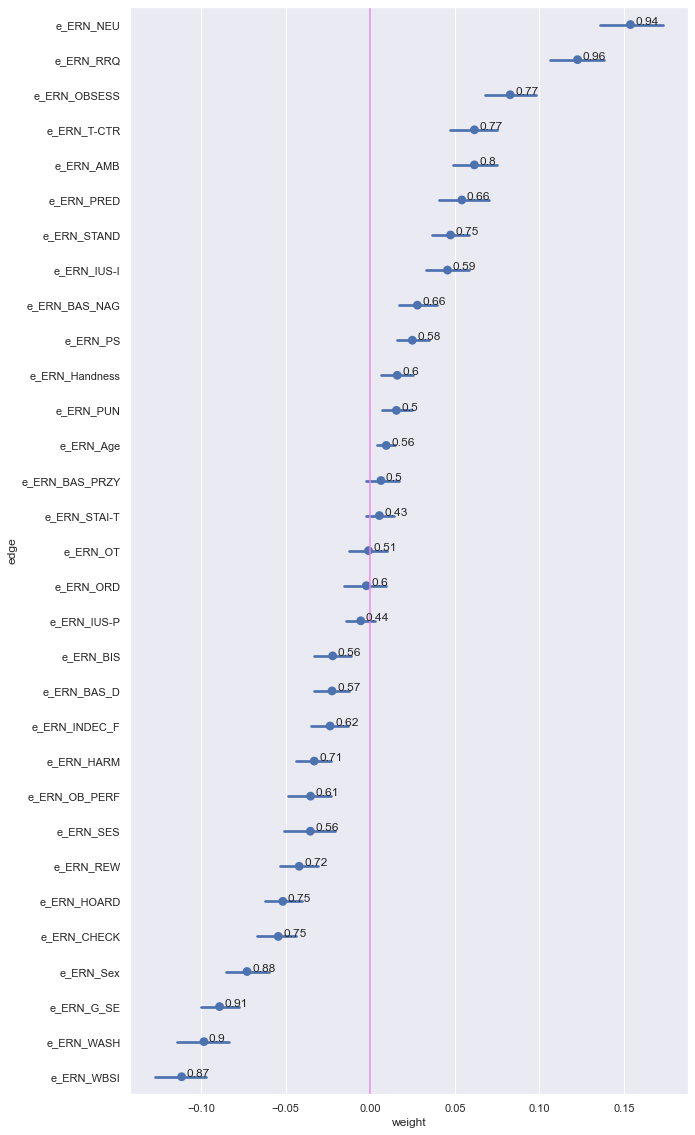

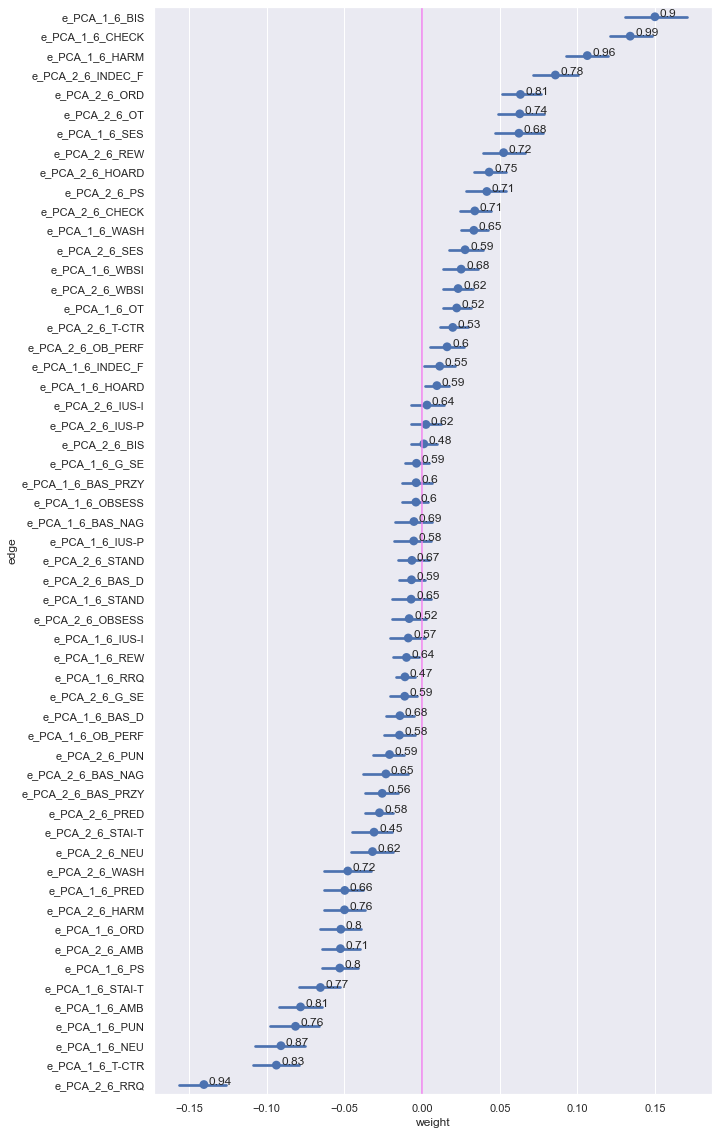

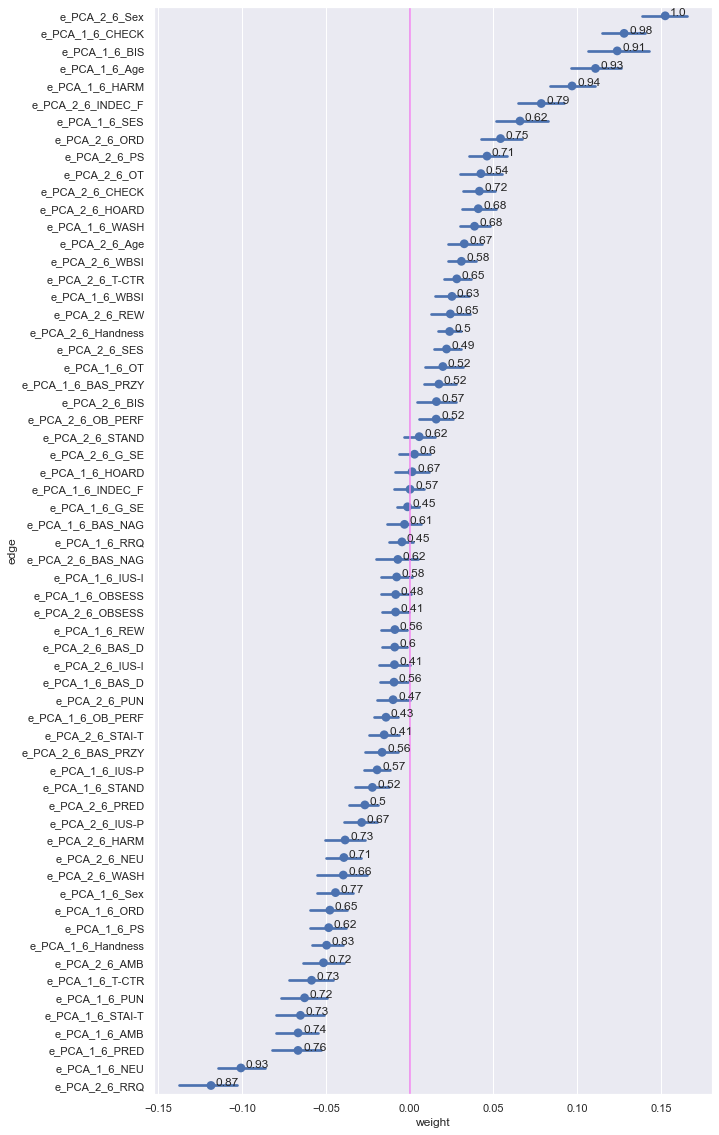

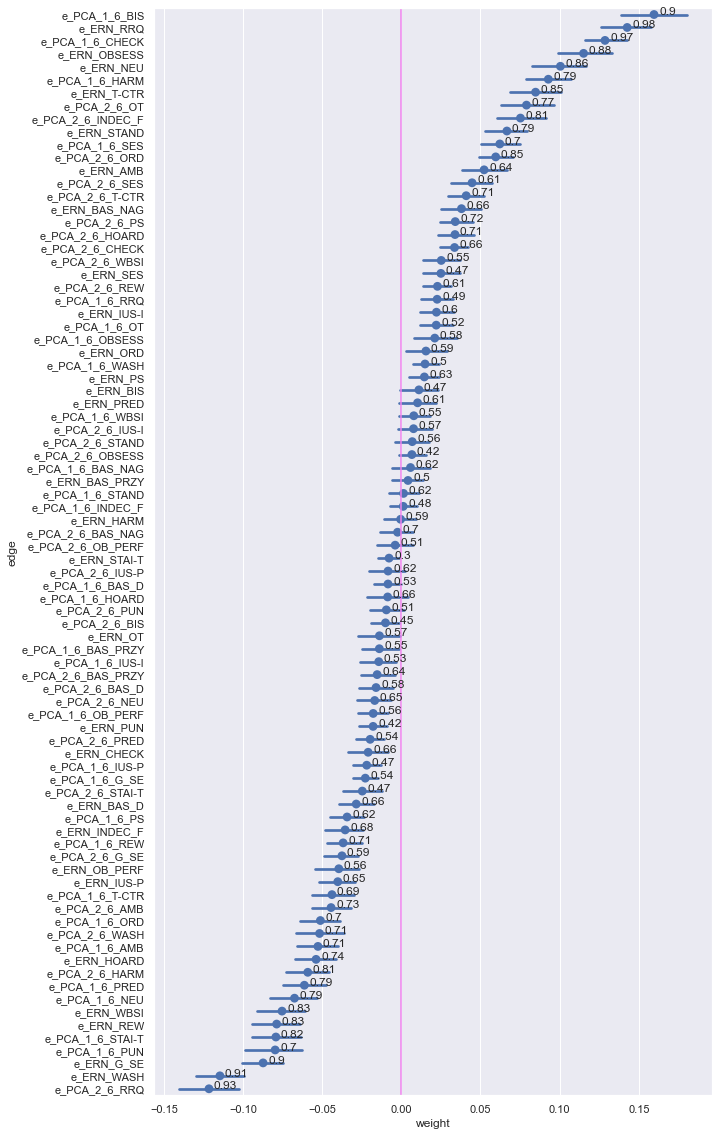

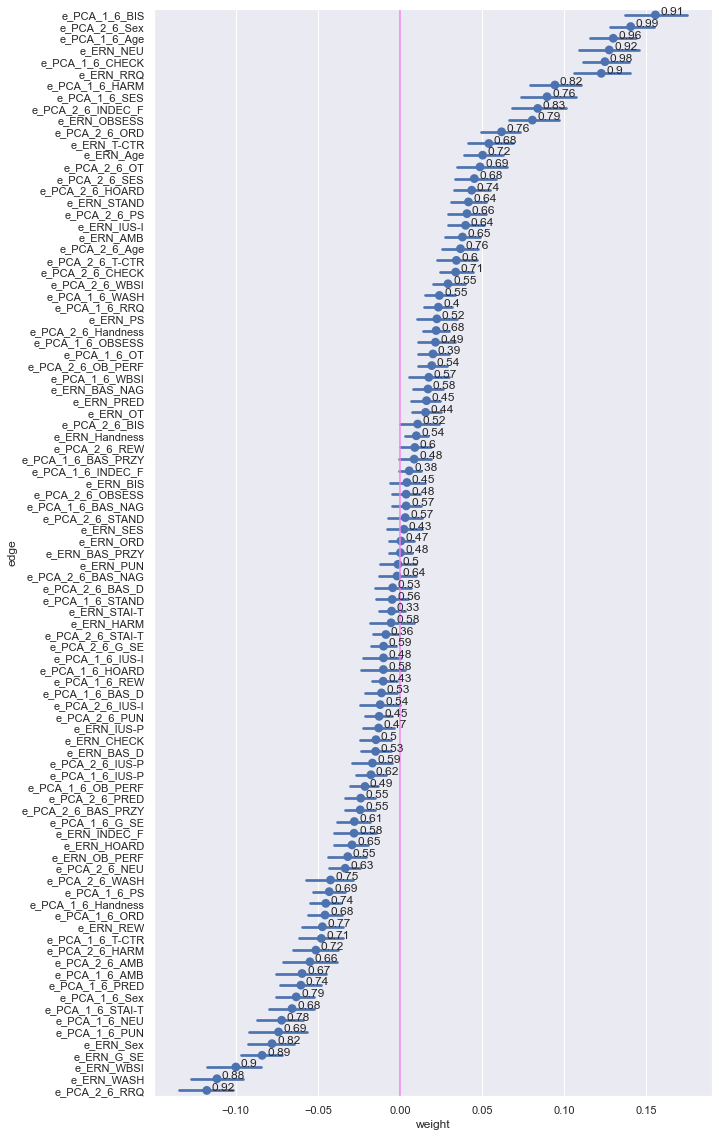

In [49]:
if test:
    print(f"Test set")

    for i,model in enumerate(bootstrap_samples_models_test):
        plt.figure(i)
        plot_eeg_links_bootstrapping_results(model)
        
        
else:
    print(f"Train set")
    
    for i,model in enumerate(bootstrap_samples_models):
        plt.figure(i)
        plot_eeg_links_bootstrapping_results(model)

### Similarity of network

#### Correlation links similarity

In [200]:
def get_matrix_triu_as_list(matrix, threshold = 0.02):
    
    precision_matrix_df = matrix.where(np.triu(np.ones(matrix.shape)).astype(np.bool))
    precision_matrix_df = precision_matrix_df.mask(abs(precision_matrix_df) <= threshold, 0.0)

    links = precision_matrix_df.stack().reset_index()
    links.columns = ['var1', 'var2','weight']
    links=links.loc[(links['var1'] != links['var2']) ]
    
    return links['weight'].to_numpy()

In [201]:
def pearsonr_links_similarity(matrix1, matrix2):
    links1 = get_matrix_triu_as_list(matrix1)
    links2 = get_matrix_triu_as_list(matrix2)
    
    corr, p_value = pearsonr(links1, links2)
    
    return corr, p_value

In [202]:
for i in range(0, len(precision_matrixes)):
    corr, p_value = pearsonr_links_similarity(precision_matrixes[i], precision_matrixes_test[i])
    print(f"Correlation: {corr} p-value: {p_value}\n")

Correlation: 0.7621049187682444 p-value: 2.779565176838424e-78

Correlation: 0.7371562730995143 p-value: 3.16435761543025e-97

Correlation: 0.7599832310362713 p-value: 4.751317946196422e-83

Correlation: 0.7288233707696185 p-value: 1.2715114448785093e-99

Correlation: 0.7651144574041724 p-value: 1.4644679604637956e-90

Correlation: 0.7404617159931426 p-value: 1.822268578432122e-110



#### Cosine links similarity

In [203]:
def cosine_links_similarity(matrix1, matrix2):
    links1 = get_matrix_triu_as_list(matrix1).reshape(1, -1)
    links2 = get_matrix_triu_as_list(matrix2).reshape(1, -1)
    
    similarity = cosine_similarity(links1, links2)[0][0]
    
    return similarity

In [204]:
for i in range(0, len(precision_matrixes)):
    similarity = cosine_links_similarity(precision_matrixes[i], precision_matrixes_test[i])
    print(f"Cosine similarity: {similarity}\n")

Cosine similarity: 0.7806913585128975

Cosine similarity: 0.7519358593019443

Cosine similarity: 0.7781045842101735

Cosine similarity: 0.742527717463127

Cosine similarity: 0.7786326288273065

Cosine similarity: 0.7514529065739666



####  [Levenshtein distance](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.optimize_graph_edit_distance.html)

In [ ]:
# similarities = []

# if test:
#     for graphs_ in (graphs, test_graphs):
#         G1 = graphs_[0]
#         G2 = graphs_[1]
#         similarity = nx.graph_edit_distance(G1, G2, timeout=10800)
#         similarities.append(similarity)

In [ ]:
similarities = []

if test:
    for i in range(0,len(graphs)):
        print(graphs[i])
        print(test_graphs[i])
        G1 = graphs[i]
        G2 = test_graphs[i]
        similarity = nx.optimize_graph_edit_distance(G1, G2)
        similarities.append(similarity)

In [ ]:
for v in similarities[0]:
    minv = v
    print(minv)

## ERN and CRN graphs difference

### 1. Continuous: Based on precision matrixes

In [224]:
ern_precision = precision_matrixes[0]
ern_cov_precision = precision_matrixes[1]
crn_precision = precision_matrixes[2]
crn_cov_precision = precision_matrixes[3]

In [226]:
ern_cov_precision

e_ERN     e_Lat  e_Lateral       Age       Sex  Handness  \
e_ERN      1.218953 -0.089664  -0.409966  0.000000 -0.059866  0.000000   
e_Lat     -0.089664  1.092571  -0.227488  0.009284 -0.054136 -0.000000   
e_Lateral -0.409966 -0.227488   1.253733  0.022153 -0.000000  0.020037   
Age        0.000000  0.009284   0.022153  1.095004 -0.137003 -0.000000   
Sex       -0.059866 -0.054136  -0.000000 -0.137003  1.244597  0.087205   
Handness   0.000000 -0.000000   0.020037 -0.000000  0.087205  1.041341   
RRQ        0.116472 -0.009293   0.070979 -0.000000 -0.018237  0.000000   
STAI-T     0.000000  0.016868   0.000420 -0.000000  0.012407  0.011333   
BIS       -0.000000  0.000000  -0.018863  0.000000  0.213703 -0.014738   
BAS_D     -0.000000 -0.078565   0.028210 -0.000473  0.110131  0.000000   
BAS_PRZY  -0.000000 -0.015608   0.000000  0.114203 -0.097471 -0.020429   
BAS_NAG    0.000000 -0.000000   0.000000  0.094587  0.125651 -0.064167   
WASH      -0.093155  0.078358  -0.000000  0.066858  0.040687 -0.004005   
OBSESS     0.073896  0.000000   0.013668  0.073222  0.010787 -0.106660   
HOARD     -0.031177 -0.000000  -0.056499  0.000000  0.031313  0.000000   
ORD        0.000000  0.035854   0.006662  0.000000  0.000000 -0.000000   
CHECK     -0.056975 -0.000000  -0.000000  0.008781 -0.000202  0.011604   
NEU        0.146494 -0.036713  -0.100575 -0.056905 -0.134273 -0.053253   
OT        -0.000000 -0.088058  -0.000000  0.035336 -0.198298  0.088527   
WBSI      -0.077320  0.003324   0.090627 -0.038935  0.082690 -0.000000   
INDEC_F   -0.000000 -0.022550  -0.000000  0.109108  0.031954  0.091867   
PUN        0.000000 -0.000000  -0.030579  0.053003  0.000000  0.000000   
REW       -0.034184 -0.000000  -0.070035  0.094210 -0.216304 -0.036059   
HARM      -0.001918 -0.048674   0.043753 -0.000000 -0.000000 -0.000000   
G_SE      -0.067727  0.000000  -0.000000  0.023278  0.201823 -0.000000   
T-CTR      0.028775  0.000000   0.097644  0.008324 -0.043936  0.000000   
OB_PERF   -0.000000 -0.000000   0.000000  0.000000  0.177919  0.000000   
PS         0.000000  0.000000  -0.000000 -0.000000 -0.000000  0.000000   
AMB        0.072152 -0.000000   0.008540  0.001571  0.056754 -0.000000   
PRED       0.005417 -0.059338  -0.000000  0.000000 -0.000000  0.000000   
STAND      0.045334  0.000000   0.018702 -0.024170  0.000000 -0.009833   
IUS-P     -0.000000  0.000000  -0.086795  0.000000 -0.166945  0.000000   
IUS-I      0.017207  0.000000  -0.017805 -0.063281 -0.090030  0.000000   
SES       -0.000000 -0.000000   0.108915  0.000000  0.000000 -0.023570   

                RRQ    STAI-T       BIS     BAS_D  ...      G_SE     T-CTR  \
e_ERN      0.116472  0.000000 -0.000000 -0.000000  ... -0.067727  0.028775   
e_Lat     -0.009293  0.016868  0.000000 -0.078565  ...  0.000000  0.000000   
e_Lateral  0.070979  0.000420 -0.018863  0.028210  ... -0.000000  0.097644   
Age       -0.000000 -0.000000  0.000000 -0.000473  ...  0.023278  0.008324   
Sex       -0.018237  0.012407  0.213703  0.110131  ...  0.201823 -0.043936   
Handness   0.000000  0.011333 -0.014738  0.000000  ... -0.000000  0.000000   
RRQ        2.021597 -0.111512 -0.273861 -0.000000  ...  0.004014  0.052568   
STAI-T    -0.111512  3.432438 -0.394704 -0.084720  ...  0.000000 -0.000000   
BIS       -0.273861 -0.394704  2.177207  0.159887  ... -0.135467  0.079208   
BAS_D     -0.000000 -0.084720  0.159887  1.520443  ...  0.000000  0.000000   
BAS_PRZY   0.000000  0.000000  0.062519 -0.355115  ...  0.000000 -0.000000   
BAS_NAG   -0.000000  0.000000 -0.242742 -0.293034  ... -0.058802  0.000000   
WASH       0.036467  0.108555  0.000000 -0.103762  ... -0.035882 -0.003472   
OBSESS    -0.556072 -0.264591 -0.000000 -0.026912  ...  0.000000 -0.103357   
HOARD     -0.000000 -0.000000 -0.000000  0.107416  ... -0.009708 -0.000000   
ORD        0.000000  0.027742 -0.000000 -0.041374  ...  0.000000  0.025041   
CHECK      0.009301 -0.000000 -0.000000 -0.000000  ... -0.105762 -0.000000   
NEU        0.000000

In [180]:
# def threshold_matrix(matrix, threshold=0.02):
#     this_matrix = matrix.mask(abs(matrix) <= threshold, 0.0)
#     np.fill_diagonal(this_matrix.values, 0.0)
    
#     return this_matrix

In [181]:
# def mask_matrix(matrix_mask, matrix_to_be_masked):
#     masked = matrix_to_be_masked.mask(matrix_mask == 0.0, 0.0)
#     return this_matrix

In [182]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Anx": "2Q",
    "STAI-T": "3Q",
    "BIS": "4Q",
    "WASH": "5Q",
    "OBSESS": "6Q",
    "HOARD": "7Q",
    "ORD": "8Q",
    "CHECK": "9Q",
    "NEU": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_ERN': "1E",
    'e_Lat': "4C",
    'e_Lateral': "5C",
}

mapping_crn = {
    "RRQ": "1Q",
    "DASS-21 Anx": "2Q",
    "STAI-T": "3Q",
    "BIS": "4Q",
    "WASH": "5Q",
    "OBSESS": "6Q",
    "HOARD": "7Q",
    "ORD": "8Q",
    "CHECK": "9Q",
    "NEU": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_CRN': "1E",
    'e_Lat_C': "4C",
    'e_Lateral_C': "5C",
}

In [183]:
# ern_precision_thresholded = threshold_matrix(ern_precision).rename(columns=mapping_ern, index=mapping_ern)
# ern_cov_precision_thresholded = threshold_matrix(ern_cov_precision).rename(columns=mapping_ern, index=mapping_ern)
# crn_precision_thresholded = threshold_matrix(crn_precision).rename(columns=mapping_crn, index=mapping_crn)
# crn_cov_precision_thresholded = threshold_matrix(crn_cov_precision).rename(columns=mapping_crn, index=mapping_crn)

In [184]:
# ern_crn_diff = np.subtract(ern_precision_thresholded, crn_precision_thresholded.mask(ern_precision_thresholded == 0.0, 0.0))
# ern_crn_cov_diff = np.subtract(ern_cov_precision_thresholded, crn_cov_precision_thresholded.mask(ern_cov_precision_thresholded == 0.0, 0.0))

In [185]:
# ern_precision_thresholded

In [186]:
# crn_precision_thresholded

Links

In [187]:
# def get_links(precision_matrix_df, threshold=0.02):
#     #prepare the matrix for network illustration
#     precision_matrix_df = precision_matrix_df.where(np.triu(np.ones(precision_matrix_df.shape)).astype(np.bool))

#     links = precision_matrix_df.stack().reset_index()
#     links.columns = ['var1', 'var2','weight']
#     links=links.loc[ (abs(links['weight']) > threshold) &  (links['var1'] != links['var2']) ]
    
#     # remove links between EEG features for clarity
#     # links = links[~((links['var1'].str.contains("e_")) & (links['var2'].str.contains("e_")))]
    
#     links = links.round(2)
    
#     return links

In [188]:
# ern_crn_diff_links = get_links(ern_crn_diff)
# ern_crn_cov_diff_links = get_links(ern_crn_cov_diff)

Graphs

In [189]:
def create_g(links, mapping):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    return G

In [190]:
ern_graph = create_g(links[0], mapping_ern)
ern_cov_graph = create_g(links[1], mapping_ern)
crn_graph = create_g(links[2], mapping_crn)
crn_cov_graph = create_g(links[3], mapping_crn)

In [191]:
# diff_edges = G_diff.edges()
# ern_edges = ern_graph.edges()
# crn_edges = crn_graph.edges()

In [199]:
# edges that was exaxtly the same are purple colored
def get_diff_graph(ern_graph, crn_graph, threshold=0.02):
    colors = []
    linestyle = []

    diff_graph = ern_graph.copy()
    ern_edges = ern_graph.edges()


    for u,v in ern_edges:
        # print(f"{u},{v},{ern_graph[u][v]['weight']}")
        if v not in crn_graph[u].keys(): # link did not exist in CRN (so there is no change)
            # colors.append('green')
            this_color = 'red' if ern_graph[u][v]['weight'] < 0 else 'blue'
            colors.append(this_color)
            linestyle.append('solid')

        elif (ern_graph[u][v]['weight'] < 0) & (crn_graph[u][v]['weight'] < 0):
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']

            if abs(diff) <= threshold:
                colors.append('purple')
                linestyle.append('solid')
            else:
                diff_graph[u][v]['weight'] = diff
                colors.append('red')
                this_linestyle = 'dashed' if diff < 0 else ':'
                linestyle.append(this_linestyle)

        elif (ern_graph[u][v]['weight'] > 0) & (crn_graph[u][v]['weight'] > 0):
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']

            if abs(diff) <= threshold:
                colors.append('purple')
                linestyle.append('solid')
            else:
                diff_graph[u][v]['weight'] = diff
                colors.append('blue')
                this_linestyle = ':' if diff < 0 else 'dashed'
                linestyle.append(this_linestyle)

        elif (ern_graph[u][v]['weight'] > 0) & (crn_graph[u][v]['weight'] < 0):
            colors.append('blue')
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']
            diff_graph[u][v]['weight'] = diff
            this_linestyle = ':' # link change the sign; the color indicate ERN sign
            linestyle.append(this_linestyle)

        elif (ern_graph[u][v]['weight'] < 0) & (crn_graph[u][v]['weight'] > 0):
            colors.append('red')
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']
            diff_graph[u][v]['weight'] = diff
            this_linestyle = ':' # link change the sign; the color indicate ERN sign
            linestyle.append(this_linestyle)
        
    return diff_graph, colors, linestyle

In [217]:
def draw_graph_diff_full(G, colors, linestyle='solid', no_purple = False, seed=1):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    palette = sns.color_palette("colorblind")
    
    if no_purple:
        edges = G.edges()
        for index, edge in enumerate(edges):
            if colors[index] == 'purple':
                G.remove_edge(edge[0], edge[1])
        G.remove_nodes_from(list(nx.isolates(G)))
        purple_indexes = [i for i, e in enumerate(colors) if e == 'purple']
        colors = [i for j, i in enumerate(colors) if j not in purple_indexes]
        linestyle = [i for j, i in enumerate(linestyle) if j not in purple_indexes]
                
    G_copy = G.copy()
    edges = G_copy.edges()
    
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
        
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G_copy.nodes()]
        
    
    # set position
    pos_i = nx.spring_layout(G_copy, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=1, seed=seed)
    pos=pos_i
    # pos = nx.kamada_kawai_layout(G_copy, pos=pos_i, scale=1)
            

    edges = G.edges()
    
    weights = []
    for u,v in edges:
        weight = G[u][v]['weight']
        # print(f"{u},{v},{weight}")
        weights.append(weight)

    edge_color = colors

    weights_alphas = []
    weight_bold = []

    for index, edge_weight in enumerate(weights):
        if colors[index] == 'purple':
            alpha = 0.25
            bold = 1.2
        elif abs(edge_weight) < 0.05:
            alpha = 0.4 
            bold = 2
        elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
            alpha = 0.45
            bold = 2
        elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
            alpha = 0.5
            bold = 3
        elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
            alpha = 0.45
            bold = 3
        else:
            alpha = 0.6
            bold = 3
        weights_alphas.append(alpha)
        weight_bold.append(bold)

    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    
    
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 200,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edgelist = G.edges(),
        edge_color = edge_color,
        style = linestyle,
        alpha=weights_alphas,
        width = weight_bold,
    )
    
    plt.show()   

ERN - CRN model

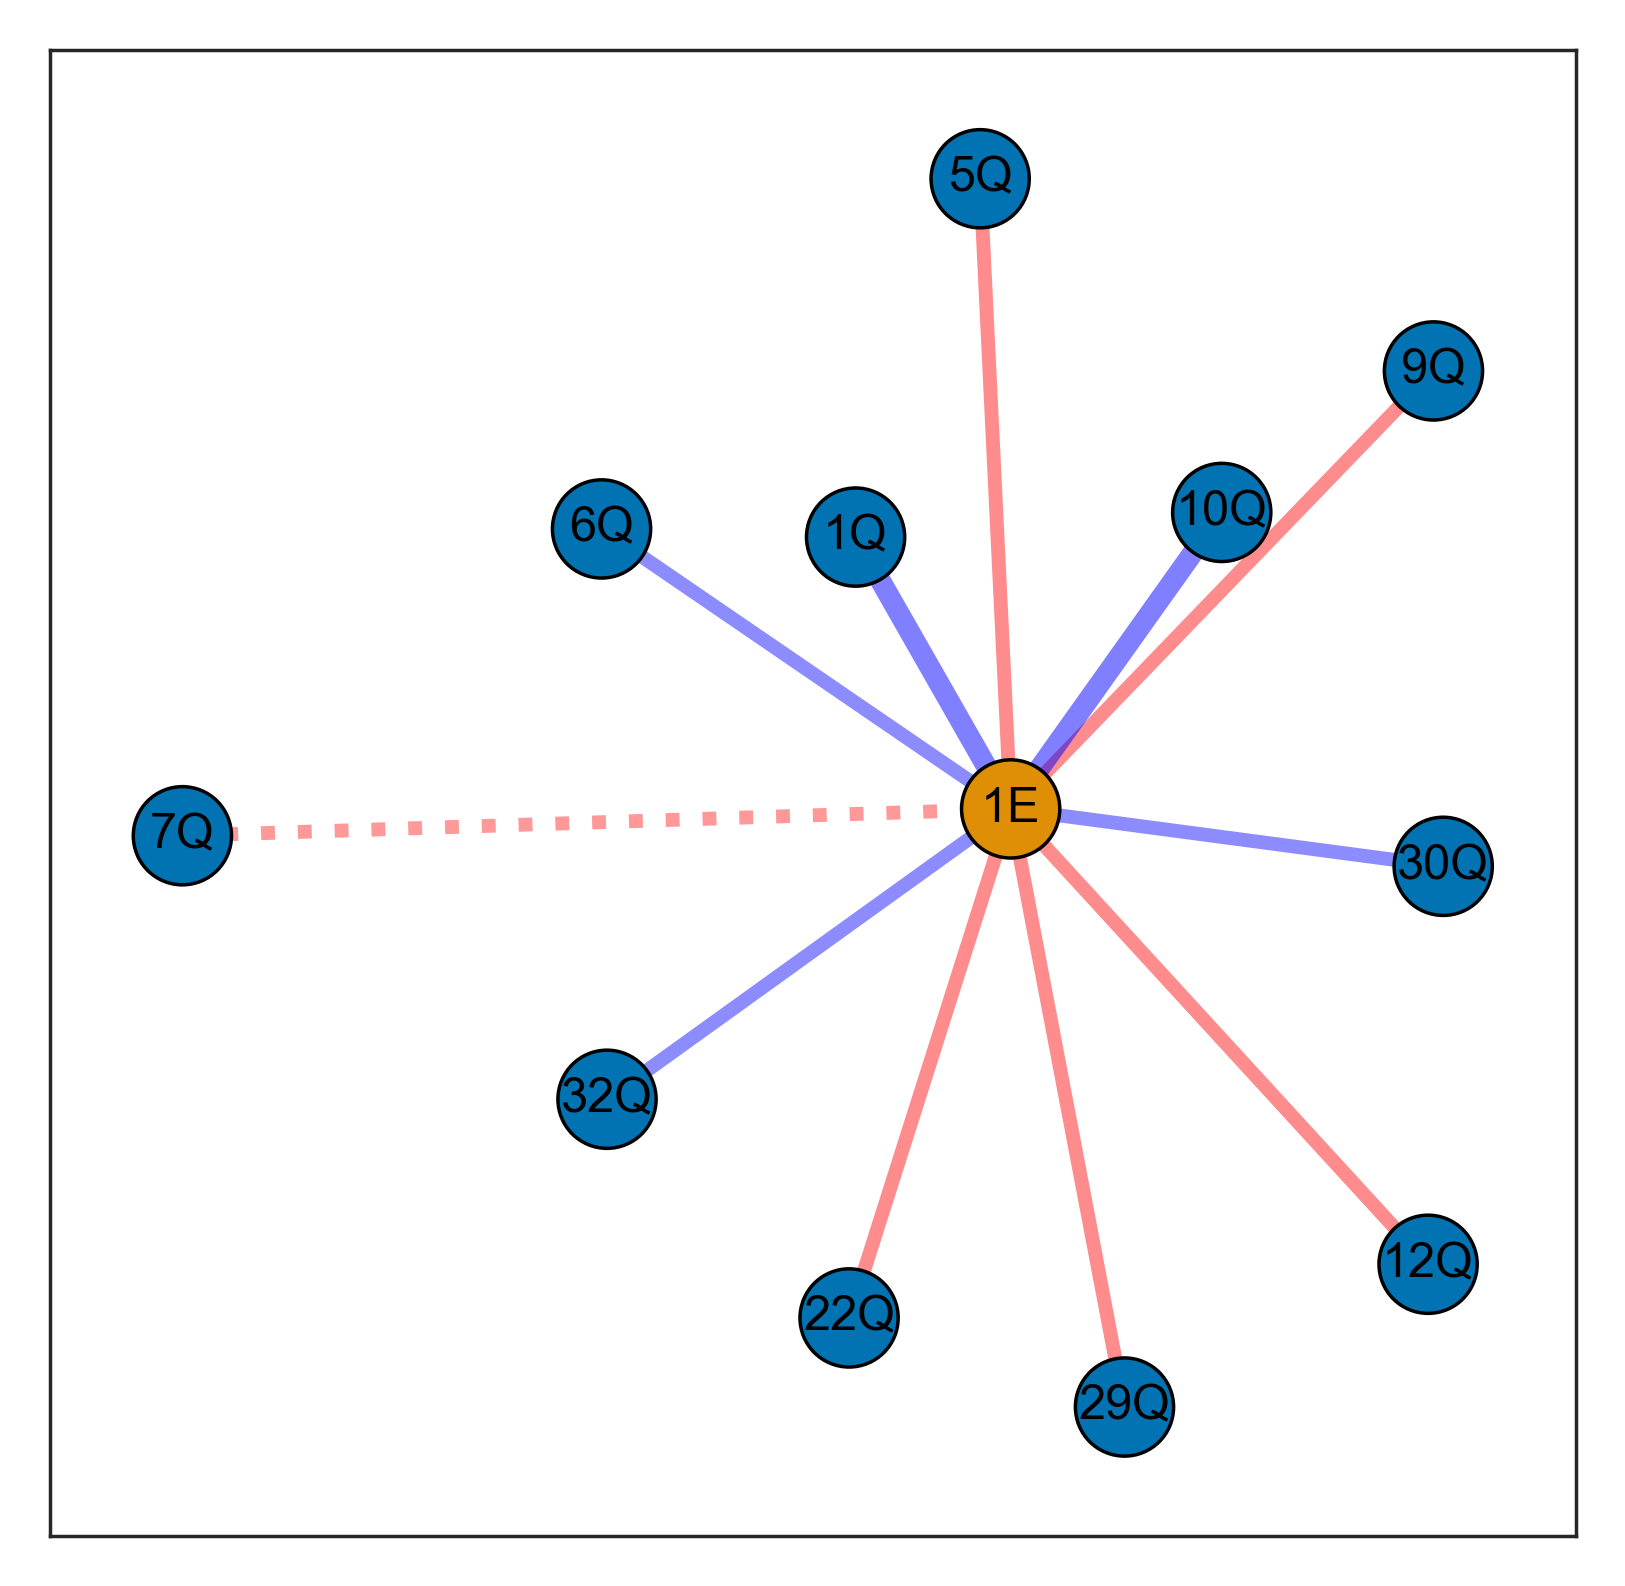

In [218]:
diff_ern, colors, styles = get_diff_graph(ern_graph, crn_graph)
draw_graph_diff_full(diff_ern, colors=colors, linestyle=styles, seed=6, no_purple=True)

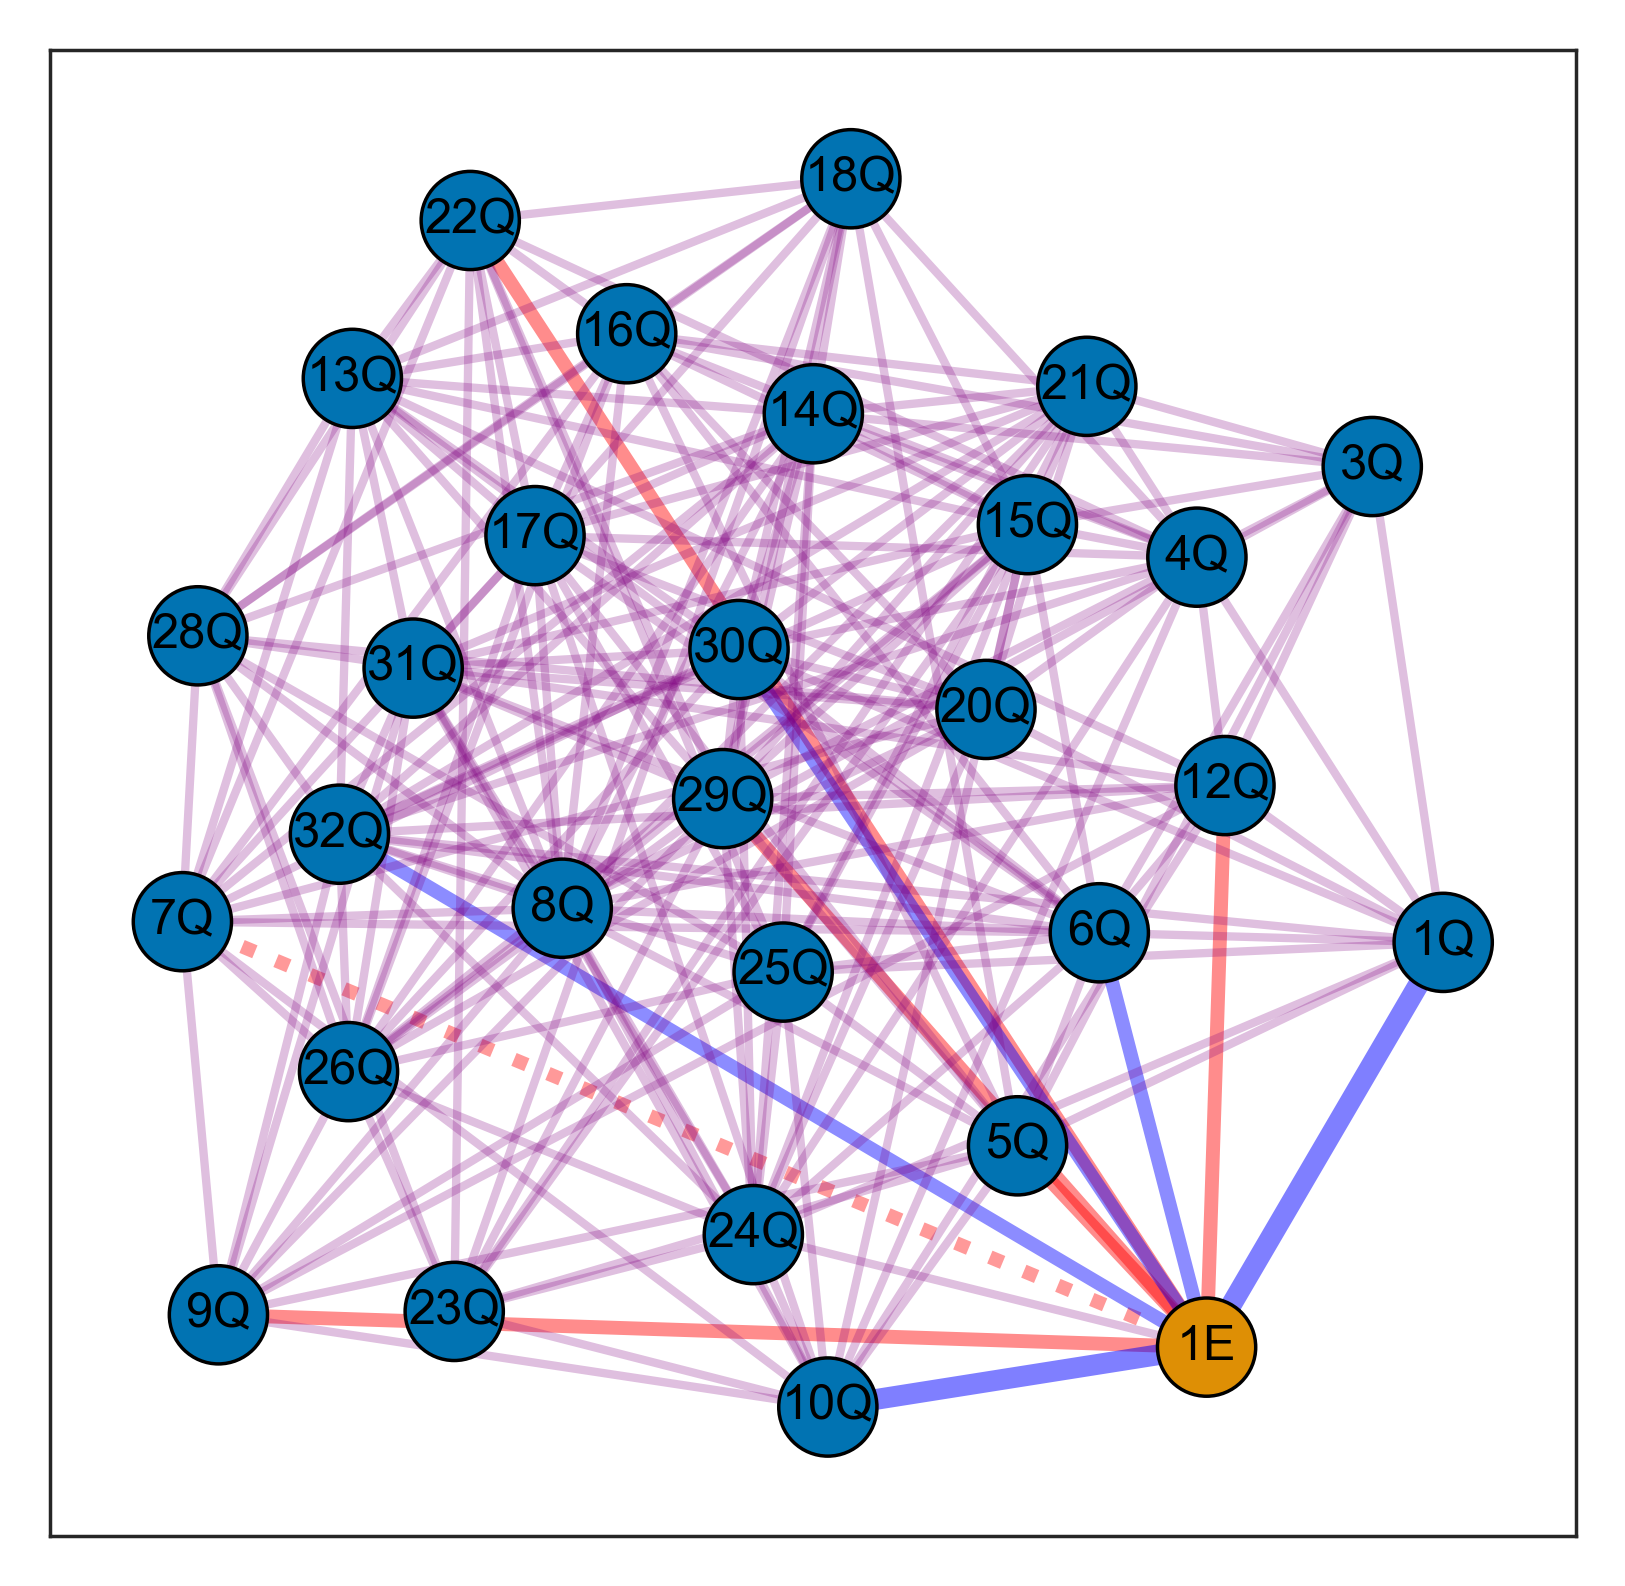

In [227]:
diff_ern, colors, styles = get_diff_graph(ern_graph, crn_graph)
draw_graph_diff_full(diff_ern, colors=colors, linestyle=styles, seed=6)

ERN + cov - CRN model

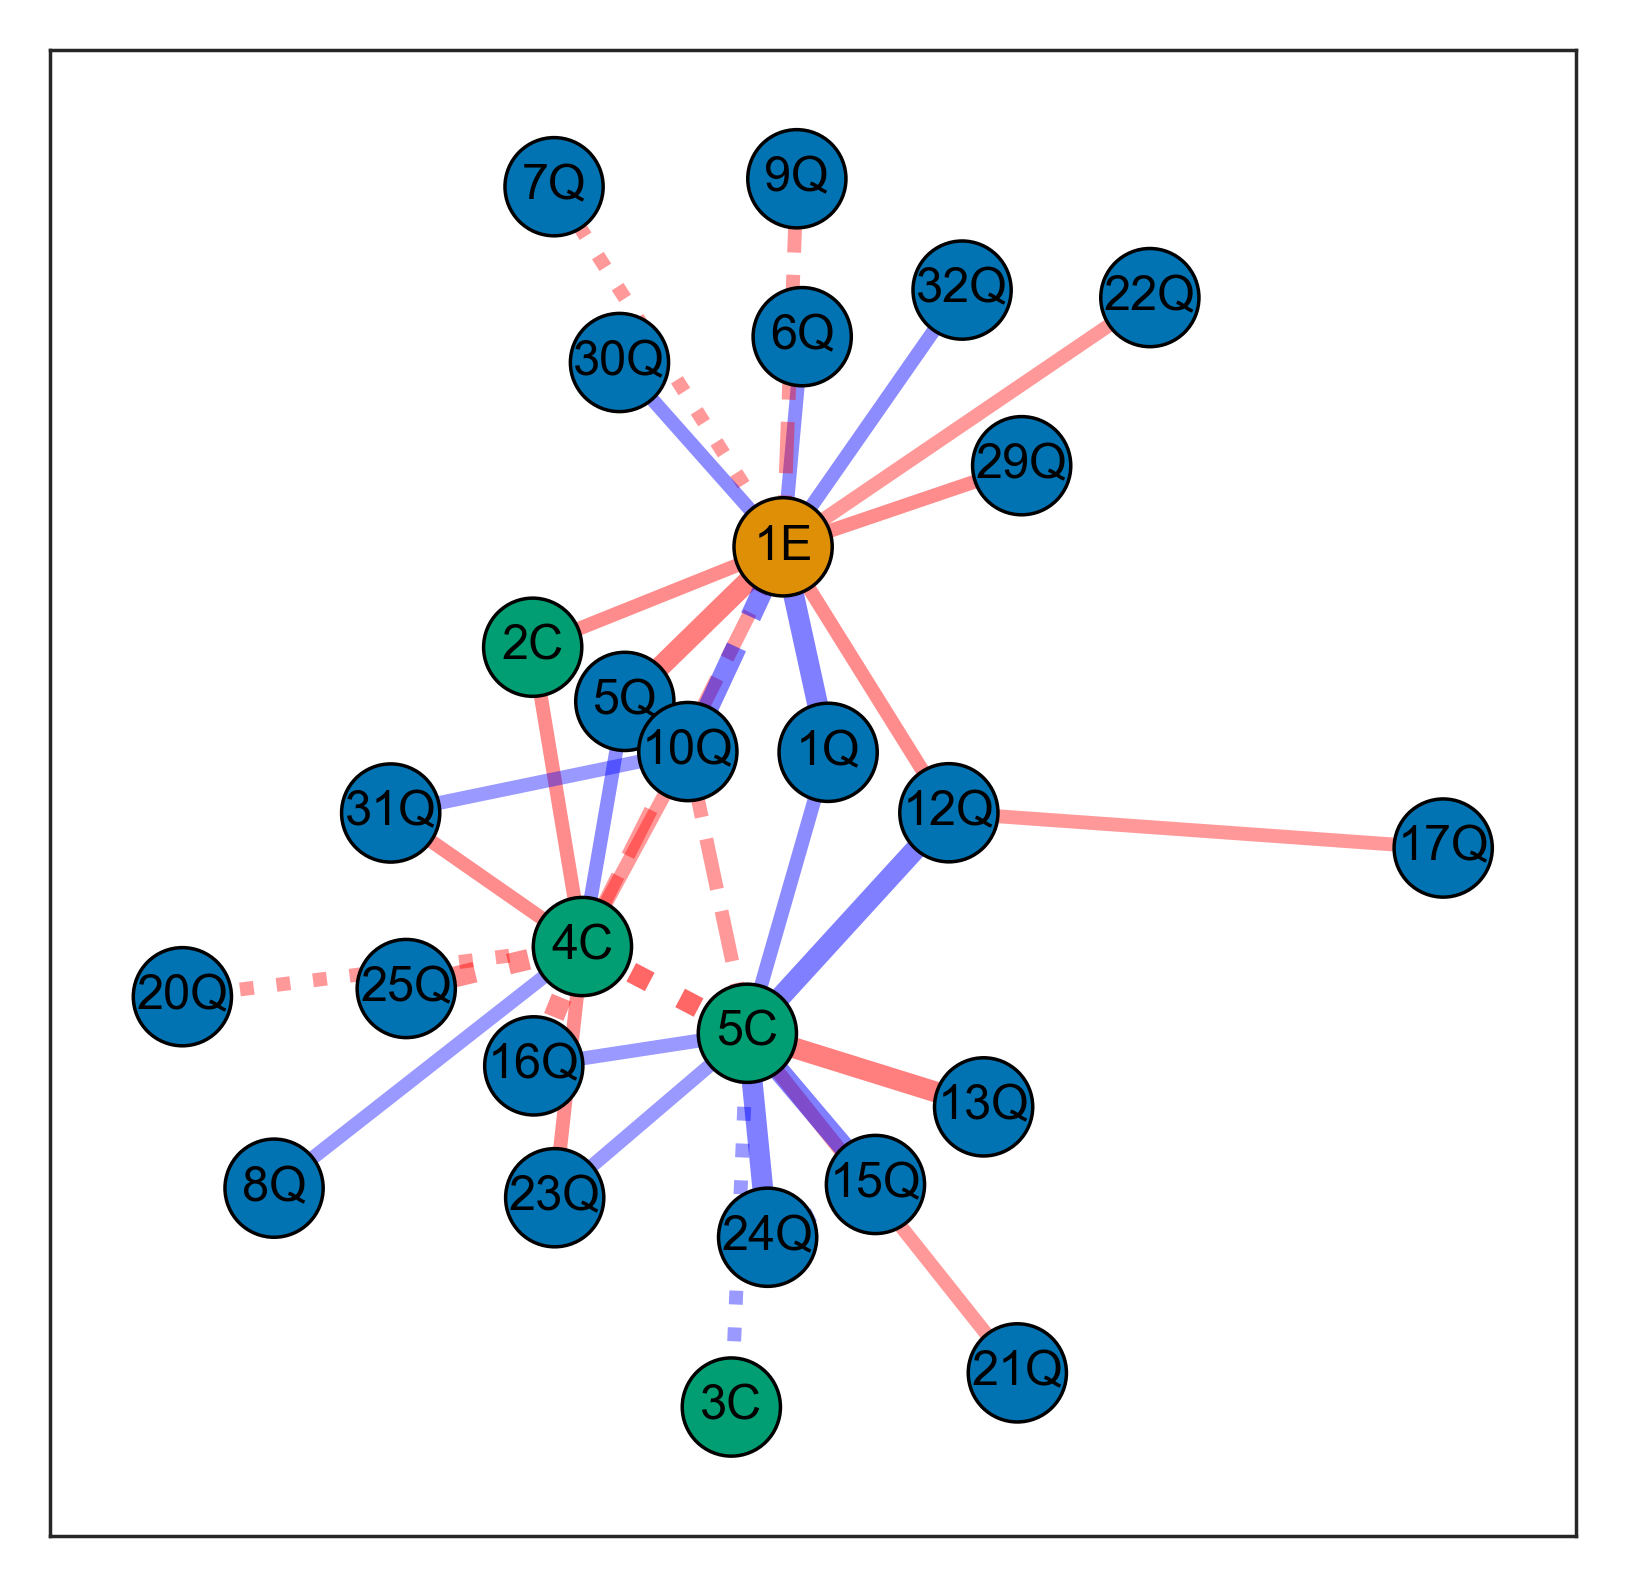

In [219]:
diff_ern, colors, styles = get_diff_graph(ern_cov_graph, crn_cov_graph)
draw_graph_diff_full(diff_ern, colors=colors, linestyle=styles, seed=1, no_purple=True)

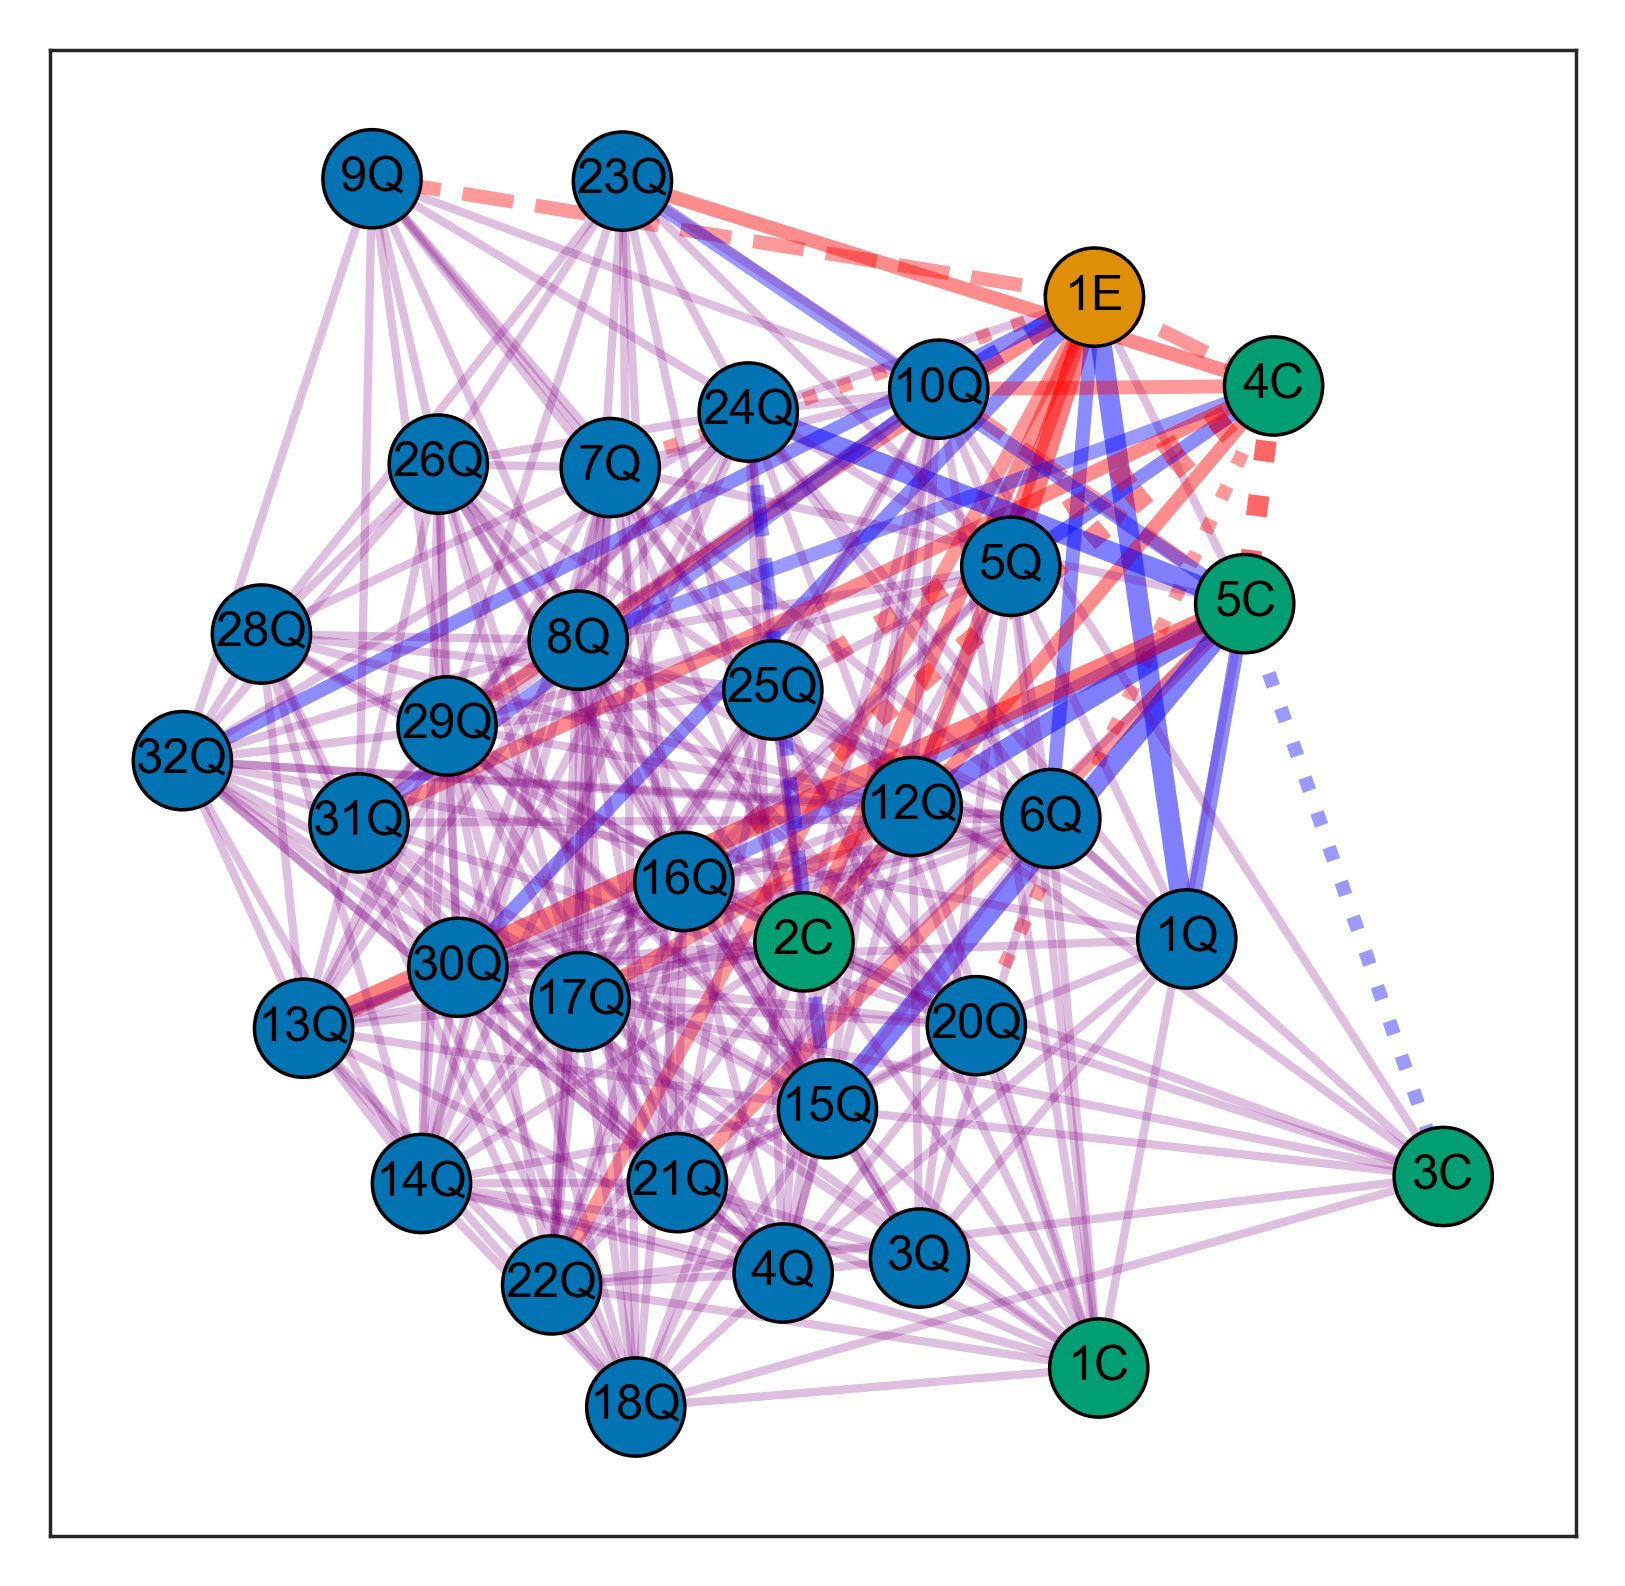

In [228]:
diff_ern, colors, styles = get_diff_graph(ern_cov_graph, crn_cov_graph)
draw_graph_diff_full(diff_ern, colors=colors, linestyle=styles, seed=1)

### 2. Based on links: ERN \ (ERN & CRN)

Leave only EEG links

In [65]:
eeg_links = []
for this_links in links:
    # this_eeg_links = leave_n_edges_from_eeg(this_links, N=0)
    this_eeg_links = this_links
    eeg_links.append(this_eeg_links)

Create graphs from links

In [66]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Anx": "2Q",
    "STAI-T": "3Q",
    "BIS": "4Q",
    "WASH": "5Q",
    "OBSESS": "6Q",
    "HOARD": "7Q",
    "ORD": "8Q",
    "CHECK": "9Q",
    "NEU": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_ERN': "1E",
    'e_Lat': "4C",
    'e_Lateral': "5C",
}

mapping_crn = {
    "RRQ": "1Q",
    "DASS-21 Anx": "2Q",
    "STAI-T": "3Q",
    "BIS": "4Q",
    "WASH": "5Q",
    "OBSESS": "6Q",
    "HOARD": "7Q",
    "ORD": "8Q",
    "CHECK": "9Q",
    "NEU": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_CRN': "1E",
    'e_Lat_C': "4C",
    'e_Lateral_C': "5C",
}

In [67]:
def create_g(links, mapping):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    return G

In [68]:
ern_graph = create_g(eeg_links[0], mapping_ern)
ern_cov_graph = create_g(eeg_links[1], mapping_ern)
crn_graph = create_g(eeg_links[2], mapping_crn)
crn_cov_graph = create_g(eeg_links[3], mapping_crn)

#### ERN - CRN graph

In [69]:
diff_graph = ern_graph.copy()

for edge in diff_graph.edges():
    
    if edge in crn_graph.edges():
        diff_graph.remove_edge(edge[0], edge[1])
diff_graph.remove_nodes_from(list(nx.isolates(diff_graph)))

In [70]:
diff_graph_cov = ern_cov_graph.copy()

for edge in diff_graph_cov.edges():
    
    if edge in crn_cov_graph.edges():
        diff_graph_cov.remove_edge(edge[0], edge[1])
diff_graph_cov.remove_nodes_from(list(nx.isolates(diff_graph_cov)))

In [71]:
def draw_graph_diff(G, seed=1):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    palette = sns.color_palette("colorblind")
            
    G_copy = G.copy()
    edges = G_copy.edges()
    
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
        
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G_copy.nodes()]
        
    
    # set position
    pos_i = nx.spring_layout(G_copy, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=1, seed=seed)
    pos=pos_i
    # pos = nx.kamada_kawai_layout(G_copy, pos=pos_i, scale=1)
    
    edges = G.edges()
    # print(edges)
           
    weights = []
    for u,v in edges:
        weight = G[u][v]['weight']
        # print(f"{u},{v},{weight}")
        weights.append(weight)

    edge_color = [('red' if edge < 0 else 'blue') for edge in weights]

    weights_alphas = []
    weight_bold = []
    
    for edge_weight in weights:
        if abs(edge_weight) < 0.05:
            alpha = 0.3 
            bold = 2
        elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
            alpha = 0.35
            bold = 2
        elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
            alpha = 0.40
            bold = 3
        elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
            alpha = 0.45
            bold = 3
        else:
            alpha = 0.6
            bold = 3
        weights_alphas.append(alpha)
        weight_bold.append(bold)
        

        
    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    
    
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 200,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edgelist = G.edges(),
        edge_color = edge_color,
        alpha=weights_alphas,
        width = weight_bold,
    )
    
    plt.show()   

[('1E', '1Q'), ('1E', '5Q'), ('1E', '6Q'), ('1E', '9Q'), ('1E', '10Q'), ('1E', '12Q'), ('1E', '22Q'), ('1E', '29Q'), ('1E', '30Q'), ('1E', '32Q')]


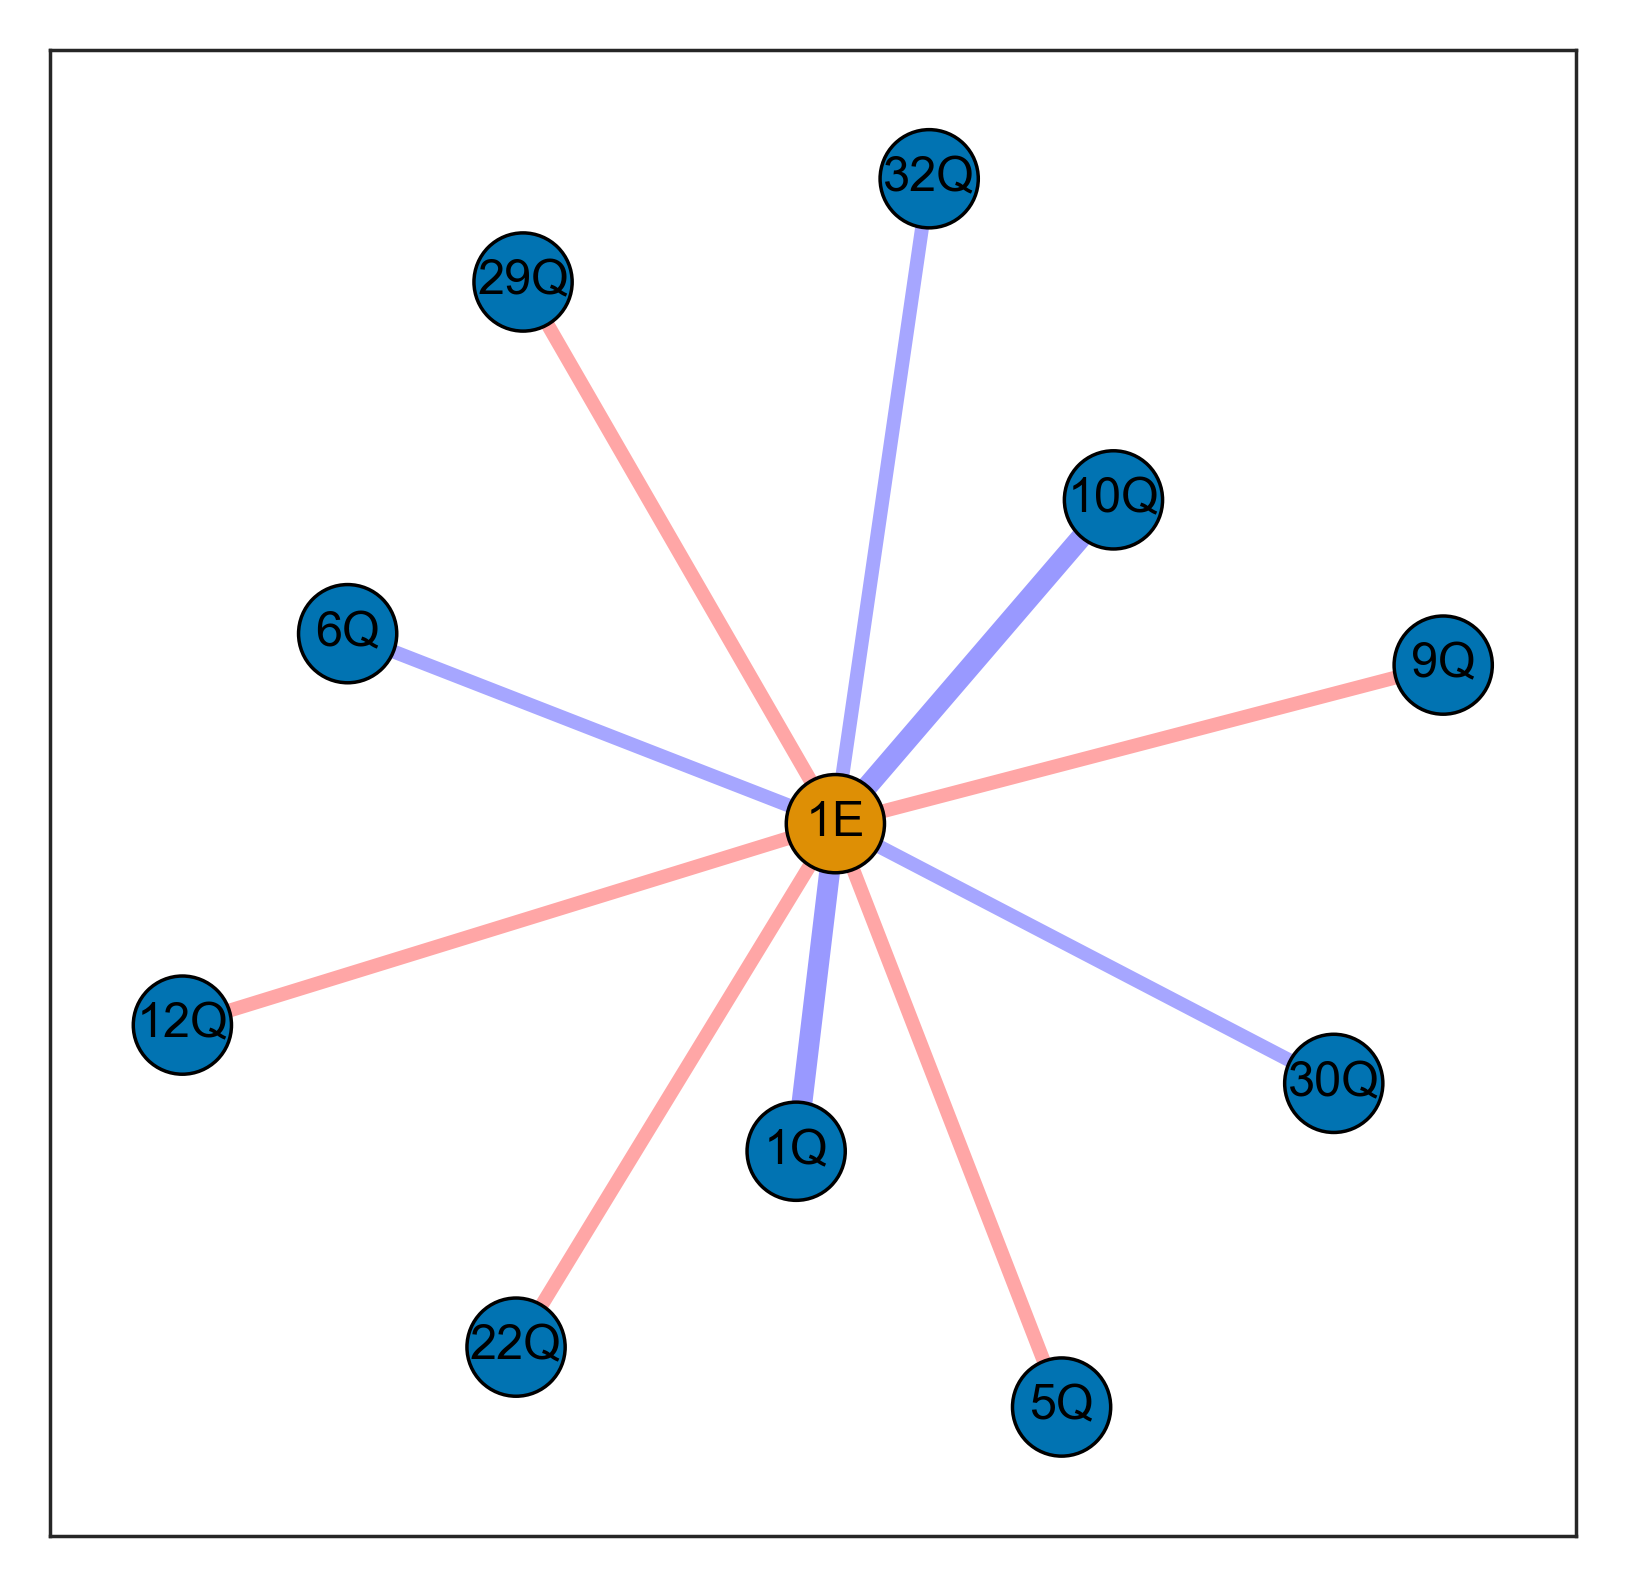

In [300]:
draw_graph_diff(diff_graph, seed=29)

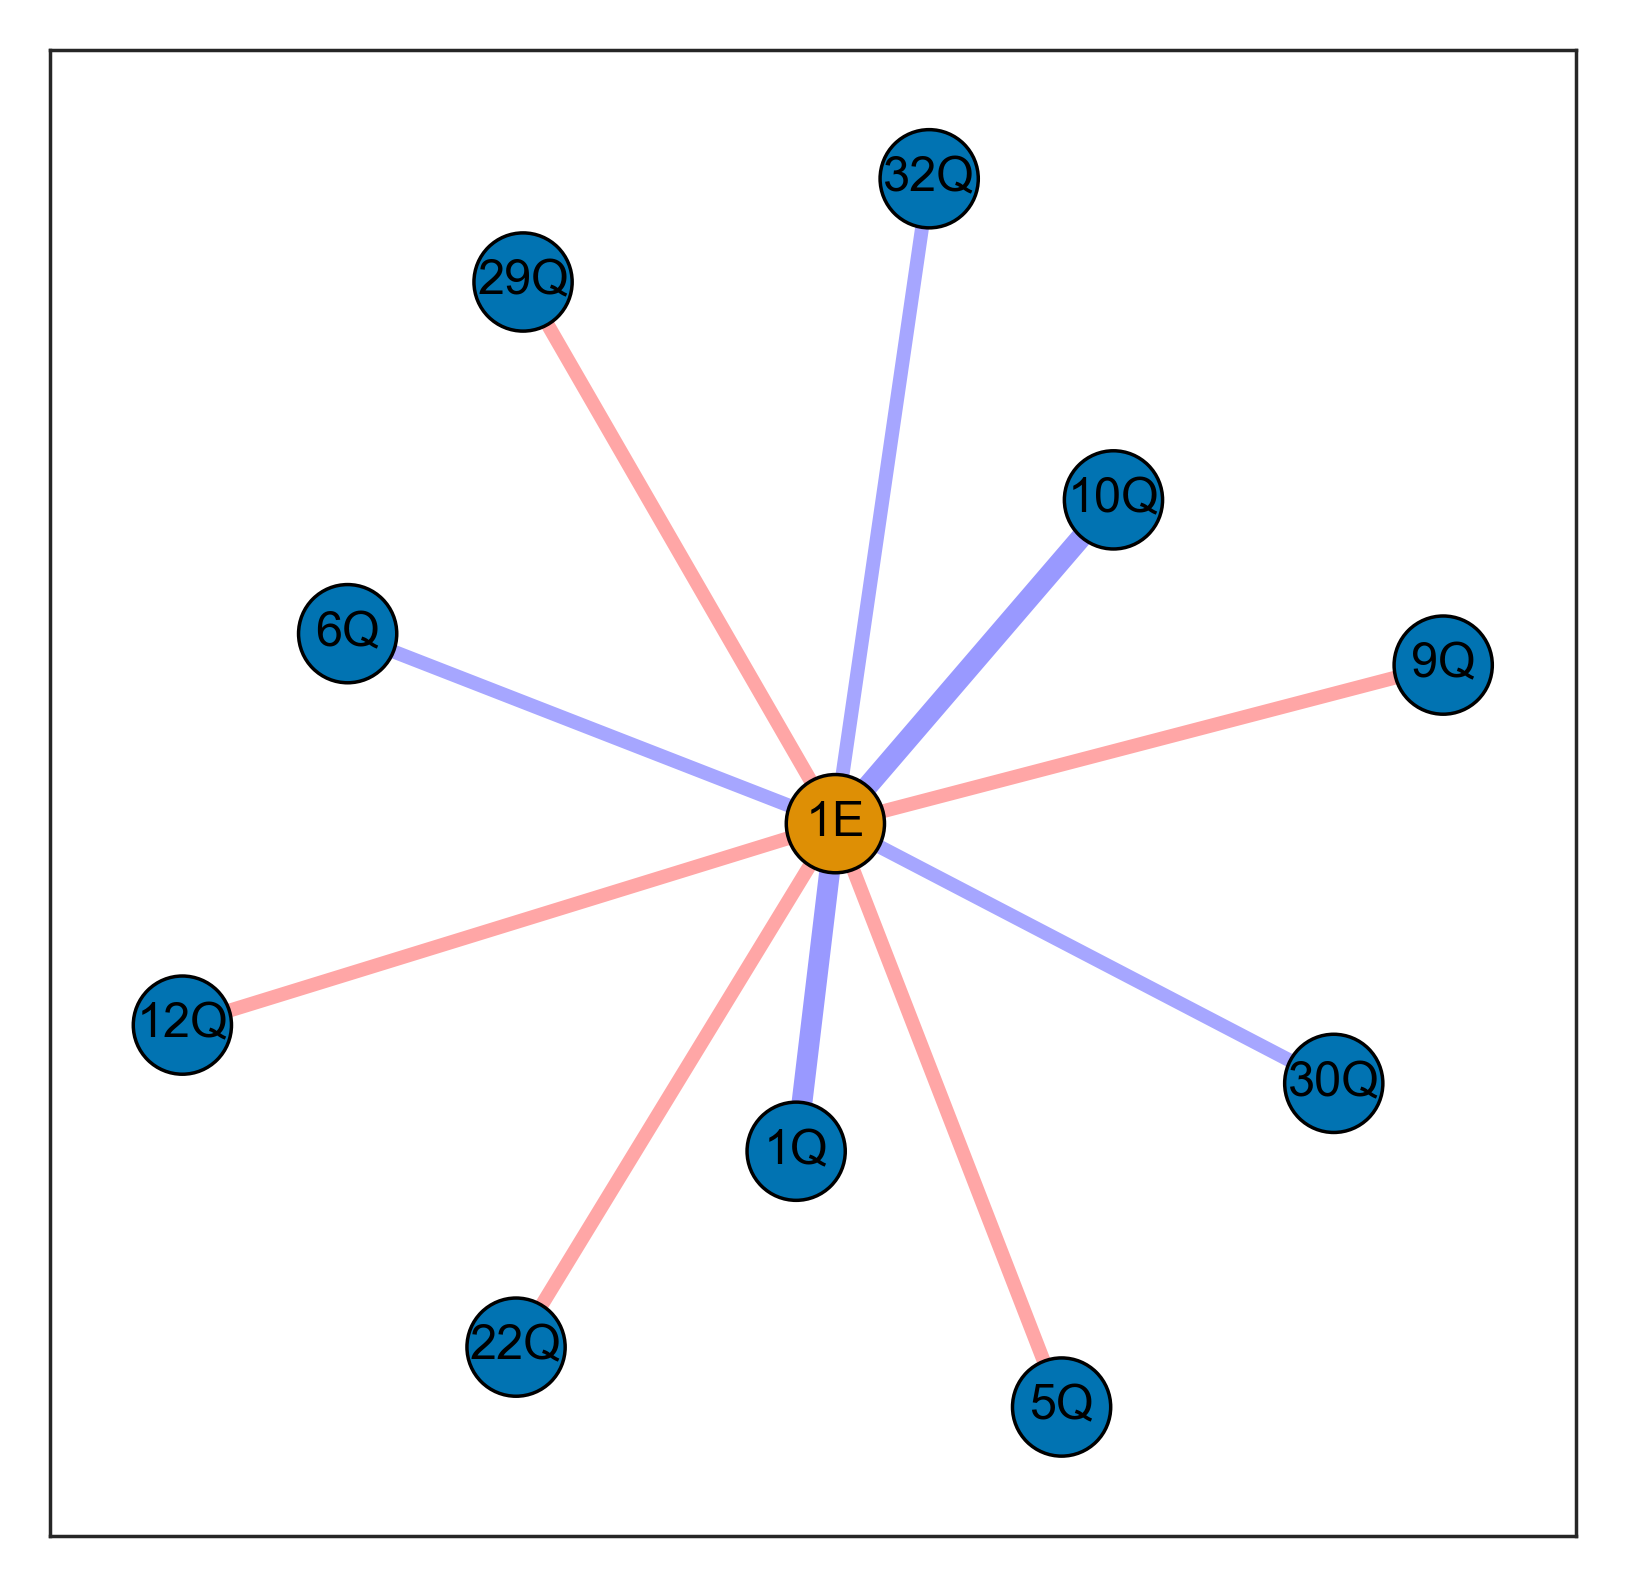

In [73]:
draw_graph_diff(diff_graph, seed=29)

[('5C', '1Q'), ('5C', '16Q'), ('5C', '12Q'), ('5C', '21Q'), ('5C', '23Q'), ('5C', '24Q'), ('5C', '13Q'), ('5C', '15Q'), ('1Q', '1E'), ('10Q', '4C'), ('12Q', '1E'), ('22Q', '1E'), ('23Q', '4C'), ('1E', '2C'), ('1E', '5Q'), ('1E', '6Q'), ('1E', '29Q'), ('1E', '30Q'), ('1E', '32Q'), ('2C', '4C'), ('5Q', '4C'), ('4C', '8Q'), ('4C', '31Q')]


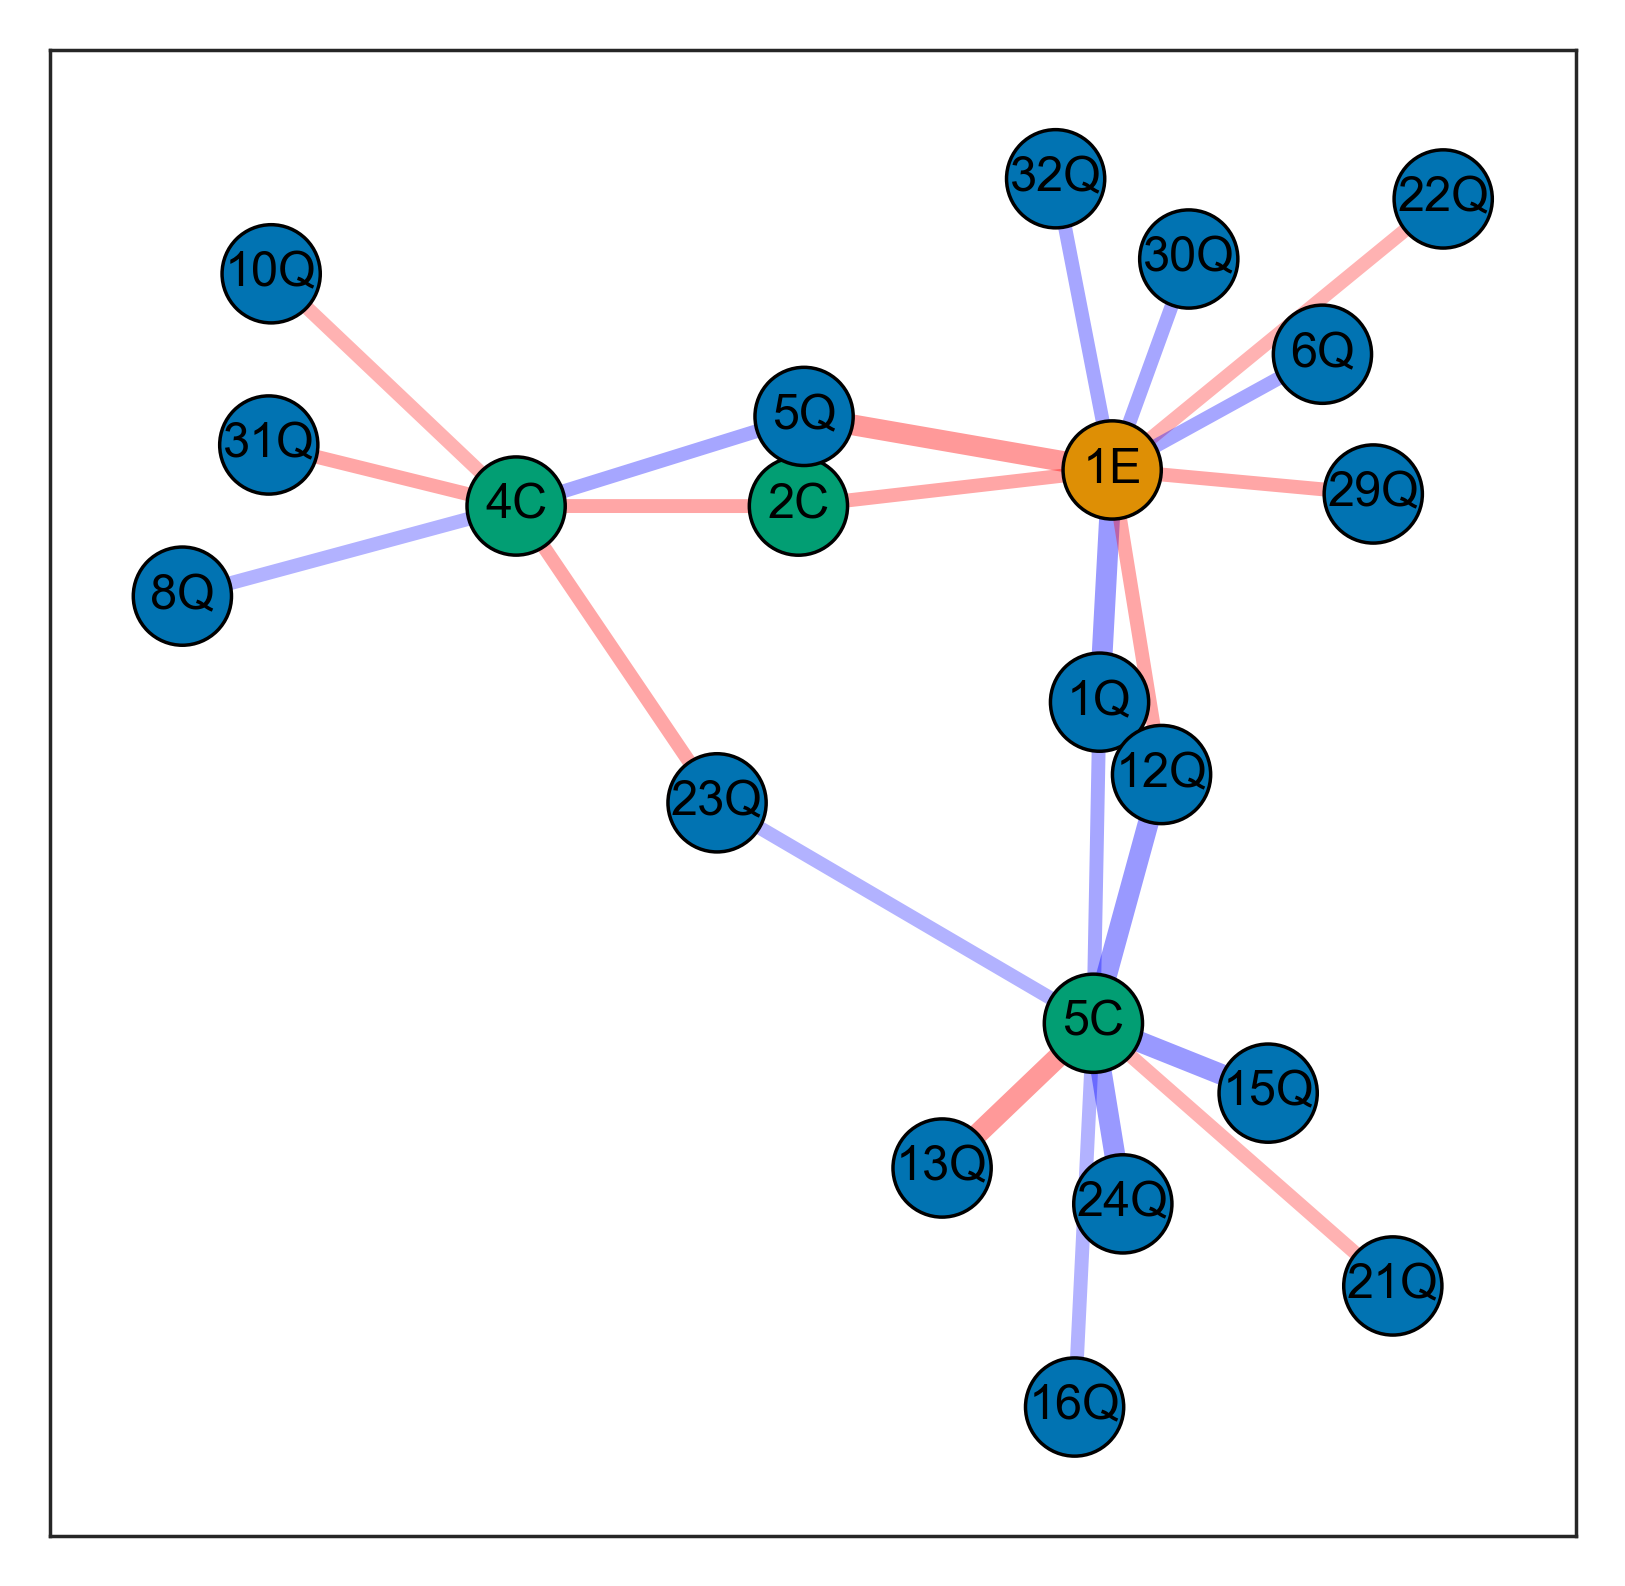

In [301]:
draw_graph_diff(diff_graph_cov, seed=6)

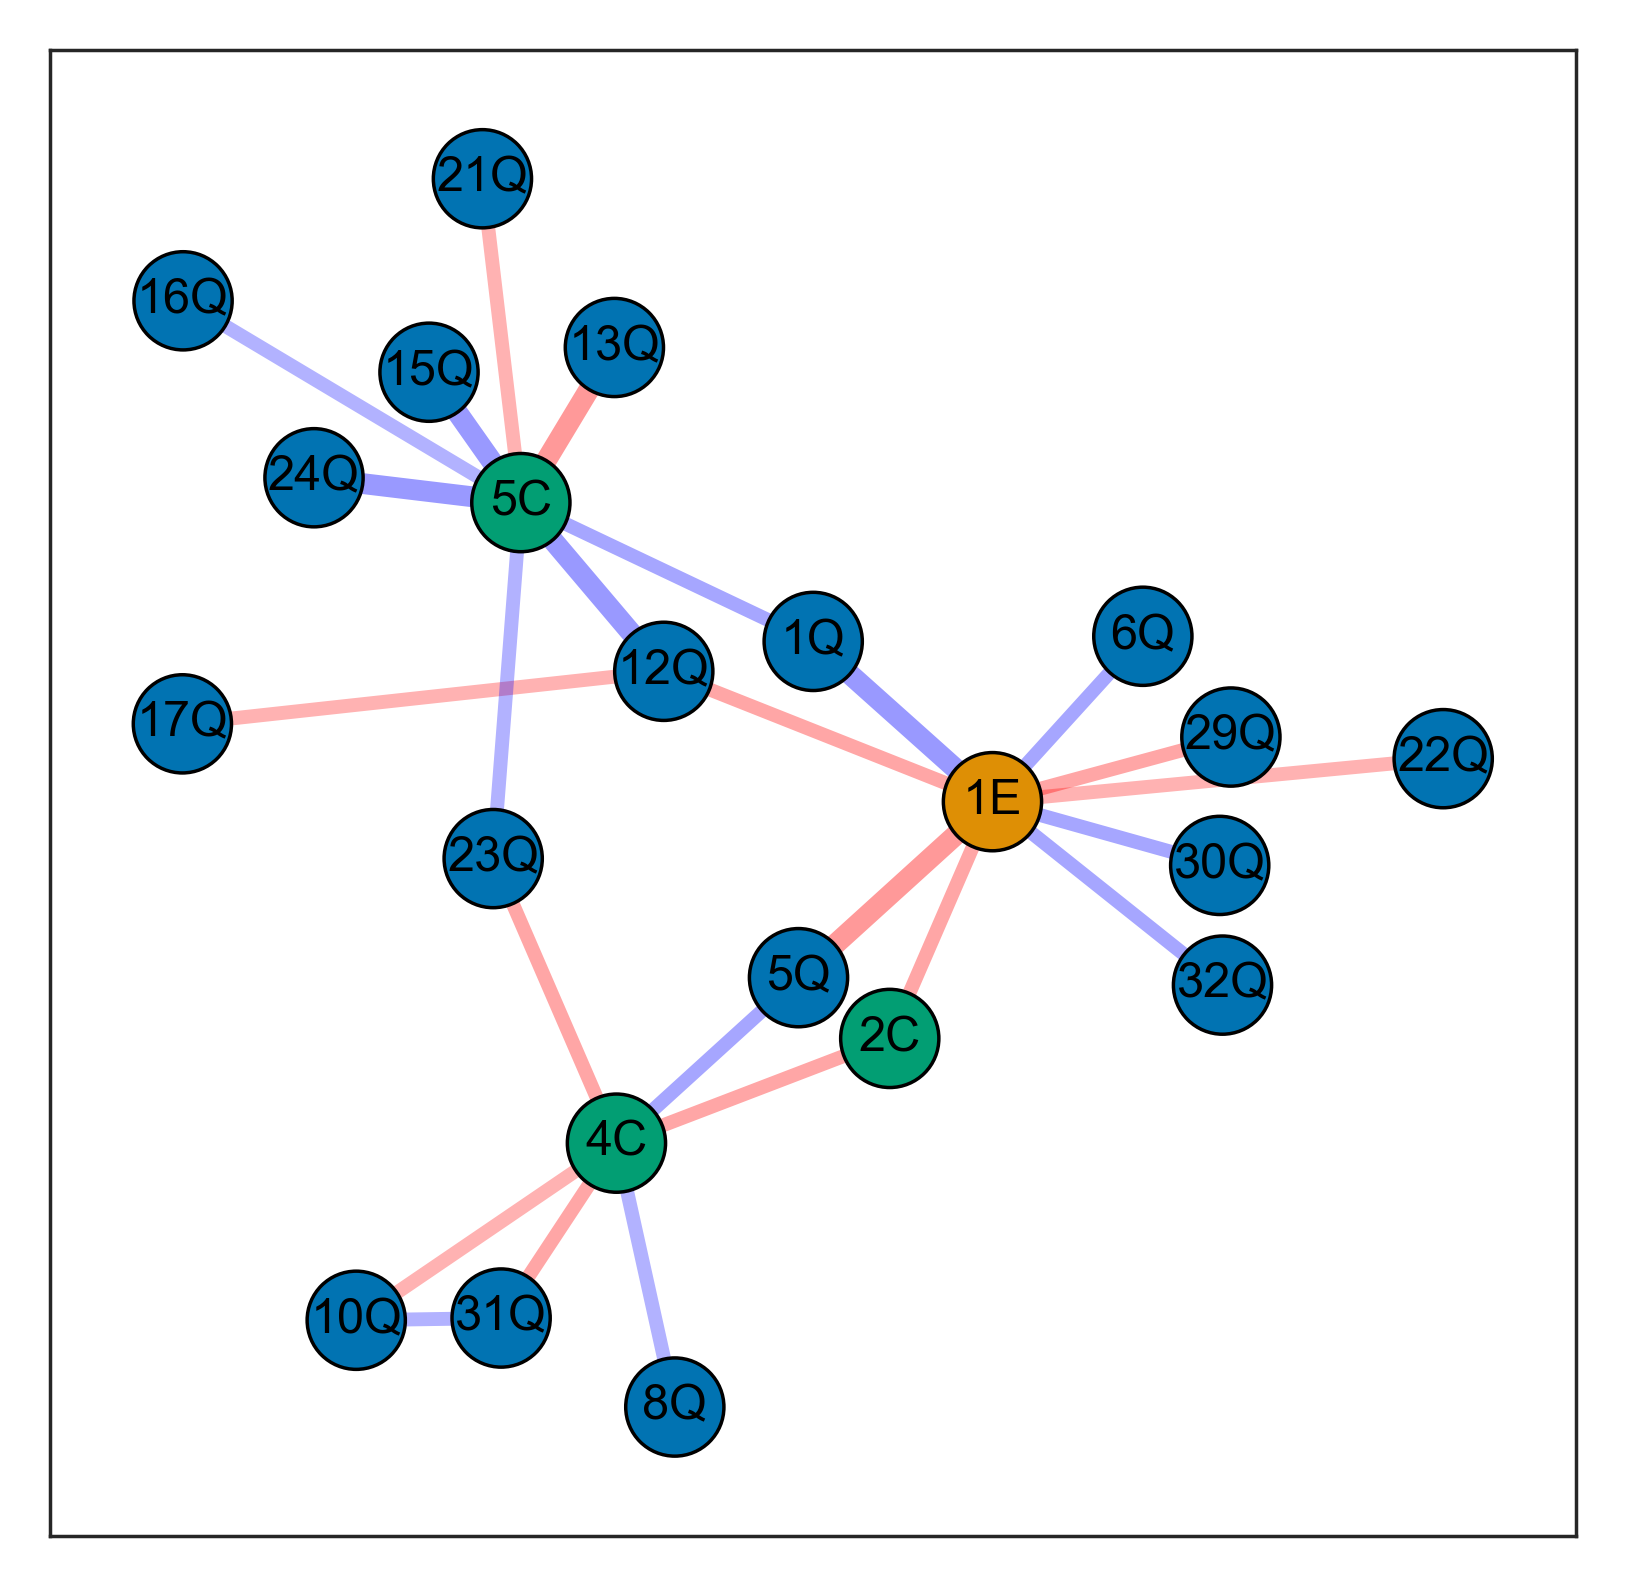

In [74]:
draw_graph_diff(diff_graph_cov, seed=6)

---
## Predictability

In [254]:
def calculate_nodes_predictability(X, precision_matrix_df, threshold=0.02):
    precision_matrix_df_mask = precision_matrix_df.mask(abs(precision_matrix_df) <= threshold, False)
    precision_matrix_df_mask = precision_matrix_df_mask.mask(abs(precision_matrix_df_mask) > threshold, True)
    
    np.fill_diagonal(precision_matrix_df_mask.values, False)

    explained_variance = []

    for node in precision_matrix_df_mask.columns:
        mask = precision_matrix_df_mask.loc[node].to_numpy()
        masked_colums = precision_matrix_df_mask.columns[mask]    
        y_ = X[[node]]
        # display(y)

        X_ = X[masked_colums]
        # display(X)

        lm = LinearRegression()
        lm.fit(X_, y_)

        score = lm.score(X_,y_)
        # print(f"Score for node {node}: {score}\n")
        explained_variance.append(score)


    explained_variance_df = pd.DataFrame(np.array(explained_variance).reshape(1,-1), columns=precision_matrix_df.columns)
    return explained_variance_df